## Utils

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

import numpy as np
import pickle, os

from matplotlib import pyplot as plt
%matplotlib inline

# from scipy import signal
from gpbayes_utils import *

In [2]:
### functions (save in a separate file)

import argparse
import sys
np.set_printoptions(threshold=sys.maxsize)

# from scipy.interpolate import interp1d, PchipInterpolator
from scipy import interpolate
from scipy.spatial.distance import cdist

def interp_centerline(centerline_array, interp_num):
    ### inputs)
    ### centerline_array : shape(len, 2)
    ### interp_num : number of sample points from interpolated line
    
    interpSpl, u = interpolate.splprep([centerline_array[:,0], centerline_array[:,1]], s=10)
    u_interp = np.linspace(0, 1, num=interp_num)
    [centerline_x_interp, centerline_y_interp] = interpolate.splev(u_interp, interpSpl, der=0)
    centerline_interp = np.column_stack((centerline_x_interp[:], centerline_y_interp[:]))

    return centerline_interp  #shape(num=100, 2)


def tag_lane(track, centerlines_dict):
    ### inputs)
    ### track : shape(len(track), 9)
    ###  => columns: frame_id, x, y, vx, vy, psi_rad, agent_type, length, width
    ### centerlines_dict : dictionary of centerlines (keys: lanes)
    
    ### output
    ### track_tagged : shape(len(track), 7)
    ###  => columns: frame_id, x, y, agent_type, length, width, lane
    
    tags = []
    for p, _ in enumerate(track):
        min_dist_dict = dict()
#         lane_idx_dict = dict()
        for lane, centerline in centerlines_dict.items():                    
            min_dist_dict[lane] = np.min(cdist(np.array([track[p, 1:3]]), centerline, 'euclidean'))
#             lane_idx_dict[lane] = np.argmin(cdist(np.array([track[p, 1:3]]), centerline, 'euclidean'))
            
        lane_tag = min(min_dist_dict, key=min_dist_dict.get)
        tags.append([lane_tag]) #, lane_idx_dict[lane_tag]])

#         if p == 0 and lane_tag != 'c':
#             print('does not start in lane c')

    tags = np.array(tags)
    track_tagged = np.column_stack((track[:, :3], track[:, 6:], tags))
    
    return track_tagged


## Load & Construct vehicle tracks and centerlines

In [3]:
### load vehicle tracks

# scene = 'DR_CHN_Merging_ZS'
# filenum = '000'

# with open('../processed/INTERACTION/%s/veh_tracks_%s.pkl' % (scene, filenum), 'rb') as f:
#     veh_tracks_000 = pickle.load(f)
# print('veh_tracks_000', type(veh_tracks_000), len(veh_tracks_000))
   
# # tracks_dict[track_id] = np.empty((len(df_id), 9), dtype=object)
# # tracks_dict[track_id][:, 0] = df_id.frame_id  #t(100ms = 0.1s)
# # tracks_dict[track_id][:, 1] = df_id.x
# # tracks_dict[track_id][:, 2] = df_id.y
# # tracks_dict[track_id][:, 3] = df_id.vx
# # tracks_dict[track_id][:, 4] = df_id.vy
# # tracks_dict[track_id][:, 5] = df_id.psi_rad
# # tracks_dict[track_id][:, 6] = df_id.agent_type
# # tracks_dict[track_id][:, 7] = df_id.length
# # tracks_dict[track_id][:, 8] = df_id.width


In [4]:
### load & construct centerlines

import re
# from ssm_gp_utils import *

centerlines_path = 'dataset/modified_centerlines_/'
centerlines_listdir = os.listdir(centerlines_path)
print(centerlines_listdir, '\n')

centerlines_dict = dict()
lanes_list = []
for _, file in enumerate(centerlines_listdir):
    lane = re.split('_', file)[1].split('.')[0]

    if lane == 'c' or lane == 'd':
        print('lane', lane)
        
        centerline = open(os.path.join(centerlines_path, file), 'r')
        centerline_temp = [line.split(",") for line in centerline.readlines()]

        centerline_array = []
        for point in centerline_temp:        
            centerline_array.append((float(point[0]), float(point[1])))     
        centerline_array = np.array(centerline_array)
        
        centerline_interp = interp_centerline(centerline_array, 100)
        print('centerline interpolation', len(centerline_array), 'to', len(centerline_interp)) #, centerline_interp)

        centerlines_dict[lane] = centerline_interp
        lanes_list.append(lane)
    
print('\ncenterlines_dict', centerlines_dict.keys())
print('lanes_list', lanes_list)


['centerlines_b1.txt', 'centerlines_b2.txt', 'centerlines_e1.txt', 'centerlines_e2.txt', 'centerlines_f2.txt', 'centerlines_f1.txt', 'centerlines_a.txt', 'centerlines_c.txt', 'centerlines_g.txt', 'centerlines_d.txt'] 

lane c
centerline interpolation 37 to 100
lane d
centerline interpolation 37 to 100

centerlines_dict dict_keys(['c', 'd'])
lanes_list ['c', 'd']


In [5]:
from cubic_spline_planner import *
from scipy.spatial.distance import cdist

#### lane_c ####
lane_c_x = centerlines_dict['c'][:,0]  
lane_c_y = centerlines_dict['c'][:,1]
# ds = 0.1  # [m] distance of each intepolated points
num = 1000  # number of intepolated points

sp_c = Spline2D(lane_c_x, lane_c_y)
lane_c_s = np.arange(0, sp_c.s[-1], sp_c.s[-1]/num)

lane_c_rx, lane_c_ry = [], []
# lane_c_ryaw, lane_c_rk = , [], []
for i in range(len(lane_c_s)):
    xi, yi = sp_c.calc_position(lane_c_s[i])
    lane_c_rx.append(xi)
    lane_c_ry.append(yi)
#     lane_c_ryaw.append(sp_c.calc_yaw(lane_c_s[i]))
#     lane_c_rk.append(sp_c.calc_curvature(lane_c_s[i]))
lane_c_rxy = np.column_stack((lane_c_rx, lane_c_ry))



#### lane_d ####
lane_d_x = centerlines_dict['d'][:,0]  
lane_d_y = centerlines_dict['d'][:,1]

sp_d = Spline2D(lane_d_x, lane_d_y)
lane_d_s = np.arange(0, sp_d.s[-1], sp_d.s[-1]/num)

lane_d_rx, lane_d_ry = [], []
for i in range(len(lane_d_s)):
    xi, yi = sp_d.calc_position(lane_d_s[i])
    lane_d_rx.append(xi)
    lane_d_ry.append(yi)
lane_d_rxy = np.column_stack((lane_d_rx, lane_d_ry))


#### center of lane_c and lane_d
lane_cd_s = np.mean([lane_c_s, lane_d_s], axis=0)
lane_cd_rxy = np.mean([lane_c_rxy, lane_d_rxy], axis=0)

lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}


In [6]:
veh_tracks_path = '../processed/INTERACTION/DR_CHN_Merging_ZS/'
veh_tracks_listdir = os.listdir(veh_tracks_path)

actual_tracks_dict_all = dict()
actual_tracks_dict_idm = dict()
actual_tracks_dict_mobil = dict()

new_id = 0
t_span_file = [0,0]

for i, file in enumerate(veh_tracks_listdir[:1]):
    with open(os.path.join(veh_tracks_path, file), 'rb') as f:
        veh_tracks_i = pickle.load(f)
    print('veh_tracks_', i, type(veh_tracks_i), len(veh_tracks_i), min(list(veh_tracks_i.keys())), max(list(veh_tracks_i.keys())))

    t_span = [0, 0]
    for veh_id, track in veh_tracks_i.items():
        if track[0, 1] > 1125 and track[0, 1] < 1140 and track[0, 2] > 954 and track[0, 2] < 963:  #lanes c,d
#         if track[0, 1] > 1125 and track[0, 1] < 1140 and track[0, 2] > 960 and track[0, 2] < 963:  #lane c
            track_tagged = tag_lane(track, centerlines_dict)
#             print('track_tagged', track_tagged[:5])

            track_tagged_t_span = np.column_stack((track_tagged[:,0] + t_span_file[1], track_tagged[:,1:]))
            actual_tracks_dict_all[10000*i + veh_id] = track_tagged_t_span
            
            if len(set(track_tagged[:, 6])) == 1:
                actual_tracks_dict_idm[10000*i + veh_id] = track_tagged_t_span
            else: 
                actual_tracks_dict_mobil[10000*i + veh_id] = track_tagged_t_span            
            
            new_id += 1
            t_min = min((t_span[0], track_tagged_t_span[0,0]))
            t_max = max((t_span[1], track_tagged_t_span[-1,0]))
            t_span = [t_min, t_max]
            
    if veh_id == list(veh_tracks_i)[-1]:
        t_span_min = min((t_span_file[0], t_span[0]))
        t_span_max = max((t_span_file[1], t_span[1]))
        t_span_file = [t_span_min, t_span_max]
#         print('t_span', t_span, 't_span_file', t_span_file)


print('\nactual_tracks_dict_all', len(actual_tracks_dict_all), actual_tracks_dict_all[33].shape, actual_tracks_dict_all[33][:1,:]) #, actual_tracks_dict.keys())
print('actual_tracks_dict_idm', len(actual_tracks_dict_idm), actual_tracks_dict_idm[33].shape) #, actual_tracks_dict.keys())
print('actual_tracks_dict_mobil', len(actual_tracks_dict_mobil), 'veh_ids', actual_tracks_dict_mobil.keys())

print('\nt_span_file', t_span_file)

veh_tracks_ 0 <class 'dict'> 684 1 689

actual_tracks_dict_all 297 (149, 7) [[7 1137.807 961.0089999999999 'car' 5.56 1.98 'c']]
actual_tracks_dict_idm 277 (149, 7)
actual_tracks_dict_mobil 20 veh_ids dict_keys([116, 137, 142, 153, 207, 208, 293, 303, 323, 338, 382, 409, 417, 442, 486, 513, 527, 574, 587, 652])

t_span_file [0, 3512]


In [7]:
### x-y coord => s-d coord
### Reference: github.com/fjp/frenet
###           "Optimal Trajectory Generation for Dynamic Street Scenarios in a Frenext Frame"


for veh_id, track in actual_tracks_dict_all.items():
    veh_d, veh_s = [], []
    veh_d_cd, veh_s_cd = [], []
    for i in range(len(track)):
        if track[i, 6] == 'c': 
            lane_rxy, lane_s = lane_c_rxy, lane_c_s
        elif track[i, 6] == 'd': 
            lane_rxy, lane_s = lane_d_rxy, lane_d_s

        ## s-d coordinate about its lane
        veh_xyi = track[i, 1:3]
        distances = cdist(np.array([veh_xyi]), lane_rxy, 'euclidean')
        veh_s.append(lane_s[np.argmin(distances)])
        if np.argmin(distances) == 0:
            lane_xyi = lane_rxy[np.argmin(distances)+1, :]
            lane_xyi_prev = lane_rxy[np.argmin(distances), :]
        else:
            lane_xyi = lane_rxy[np.argmin(distances), :]
            lane_xyi_prev = lane_rxy[np.argmin(distances)-1, :]
        [lane_dxi, lane_dyi]  = np.subtract(lane_xyi, lane_xyi_prev)
        [veh_dxi, veh_dyi] = np.subtract(veh_xyi, lane_xyi_prev)
        signi = np.sign(lane_dxi * veh_dyi - lane_dyi * veh_dxi)
        veh_d.append(np.min(distances) * signi)

        ## s-d coordinate about lane_cd_rxy
        distances_cd = cdist(np.array([veh_xyi]), lane_cd_rxy, 'euclidean')
        veh_s_cd.append(lane_cd_s[np.argmin(distances_cd)])
        
        if np.argmin(distances_cd) == 0:
            lane_xyi_cd = lane_cd_rxy[np.argmin(distances_cd)+1, :]
            lane_xyi_prev_cd = lane_cd_rxy[np.argmin(distances_cd), :]
        else:
            lane_xyi_cd = lane_cd_rxy[np.argmin(distances_cd), :]
            lane_xyi_prev_cd = lane_cd_rxy[np.argmin(distances_cd)-1, :]
        [lane_dxi_cd, lane_dyi_cd]  = np.subtract(lane_xyi_cd, lane_xyi_prev_cd)
        [veh_dxi_cd, veh_dyi_cd] = np.subtract(veh_xyi, lane_xyi_prev_cd)
        signi_cd = np.sign(lane_dxi_cd * veh_dyi_cd - lane_dyi_cd * veh_dxi_cd)
        veh_d_cd.append(np.min(distances_cd) * signi_cd)
    
    track_xy_new = np.column_stack((track[:,0:3], veh_s, veh_d, track[:,3:], veh_s_cd, veh_d_cd))
    actual_tracks_dict_all[veh_id] = track_xy_new

print('actual_tracks_dict_all', len(actual_tracks_dict_all), actual_tracks_dict_all[116].shape, actual_tracks_dict_all[116][:2,:])

# actual_tracks_dict_all[:][0] = frame_id  #t(100ms = 0.1s)
# actual_tracks_dict_all[:][1:3] = x, y
# actual_tracks_dict_all[:][3:5] = s, d
# actual_tracks_dict_all[:][5:8] = agent_type, length, width
# actual_tracks_dict_all[:][8] = lane
# actual_tracks_dict_all[:][9:11] = s_cd, d_cd  #s-d coord. about lane_cd_xy


actual_tracks_dict_all 297 (158, 11) [[424 1136.998 960.355 9.56492787105761 0.9566648829034947 'car' 4.2 1.76
  'c' 9.297836678024135 -0.9589301024614785]
 [425 1135.777 960.1239999999999 10.909995852925087 0.939903159073724
  'car' 4.2 1.76 'c' 10.647522647414736 -0.9785180383635913]]


In [8]:
import itertools

### include vel_sd, distance_headway, headway_vel_sd (within its lane)

def smoothing_vs_vd(veh_vsvd):
    w = 3  ## sliding window length
    
    veh_vsvd = np.array(veh_vsvd)
    vs, vd = veh_vsvd[:,0], veh_vsvd[:,1]
    
    vs_smooth_0 = np.convolve(vs, np.ones(w), 'valid') / w
    vs_smooth_0 = np.concatenate(([vs[0]], vs_smooth_0, [vs[-1]]))    
    vs_smooth = np.convolve(vs_smooth_0, np.ones(w), 'valid') / w
    vs_smooth = np.concatenate(([vs_smooth_0[0]], vs_smooth, [vs_smooth_0[-1]]))

    vd_smooth_0 = np.convolve(vd, np.ones(w), 'valid') / w
    vd_smooth_0 = np.concatenate(([vd[0]], vd_smooth_0, [vd[-1]]))
    vd_smooth = np.convolve(vd_smooth_0, np.ones(w), 'valid') / w
    vd_smooth = np.concatenate(([vd_smooth_0[0]], vd_smooth, [vd_smooth_0[-1]]))
    
    return np.column_stack((vs_smooth, vd_smooth))



actual_tracks_dict_all_with_headway = dict()
for veh_id, track in actual_tracks_dict_all.items():
#     if veh_id == 11 or veh_id == 116:

        veh_vsvd = []
        track_headway = []
        track_headway_prev = [None]*9
        for i in range(len(track)):
            t = track[i,0]

            if i == 0:
                veh_vsvd.append((track[i+1, 3:5] - track[i, 3:5])) # * 10) 
            else:
                veh_vsvd.append((track[i, 3:5] - track[i-1, 3:5])) # * 10) 

            dist_headway, veh_id_headway, idx_headway, lane_headway = 150, None, None, None
            track_xy_sd_headway, vsvd_headway = [None]*4, [None]*2
            
            for veh_id_other, track_other in actual_tracks_dict_all.items():
                if veh_id_other != veh_id and t >= track_other[0,0] and t <= track_other[-1,0] and track[i,8] in set(track_other[:,8]):

                    idx = np.where(track_other[:,0] == t)[0][0]      
                    dist_other = track_other[idx, 3] - track[i,3]  #dist_s
                        
                    if dist_other > 0 and dist_other < dist_headway and track[i,8] == track_other[idx,8]:
                        veh_id_headway = veh_id_other
                        idx_headway = idx
                        dist_headway = dist_other
                        track_xy_sd_headway = track_other[idx, 1:5]
                        lane_headway = track_other[idx, 8]

                        if idx == 0:
                            vsvd_headway = track_other[idx+1, 3:5] - track_other[idx, 3:5] # * 10
                        else:
                            vsvd_headway = track_other[idx, 3:5] - track_other[idx-1, 3:5] # * 10

            if veh_id_headway is None and track_headway_prev is None:
                track_headway.append([None]*10)
            elif veh_id_headway is not None:
                track_headway_prev = np.concatenate([np.array([veh_id_headway]), track_xy_sd_headway, vsvd_headway, \
                                    np.array([idx_headway]), np.array([dist_headway]), np.array([lane_headway])], axis=0)
#                 print('track_headway_prev', track_headway_prev.shape)
                track_headway.append(track_headway_prev) 
            elif veh_id_headway is None and track_headway_prev is not [None]*10:
                track_headway.append(track_headway_prev)
        veh_vsvd = smoothing_vs_vd(veh_vsvd)
        
        track_headway = np.array(track_headway)        
        actual_tracks_dict_all_with_headway[veh_id] = np.column_stack((track[:,:5], veh_vsvd, track[:,5:9], \
                                                                       track_headway, track[:,9:]))
    
print('\nactual_tracks_dict_all_with_headway', len(actual_tracks_dict_all_with_headway))
print('\nactual_tracks_dict_all_with_headway[116]', actual_tracks_dict_all_with_headway[116].shape, '\n',\
      actual_tracks_dict_all_with_headway[116][:1,:])
# print('\nactual_tracks_dict_all_with_headway[11]', actual_tracks_dict_all_with_headway[11].shape, '\n',\
#       actual_tracks_dict_all_with_headway[11][:1,:])



actual_tracks_dict_all_with_headway 297

actual_tracks_dict_all_with_headway[116] (158, 23) 
 [[424 1136.998 960.355 9.56492787105761 0.9566648829034947
  1.3450679818674764 -0.016761723829770703 'car' 4.2 1.76 'c' 114
  1124.2830000000001 958.6560000000001 22.417799697791274
  0.331996703895058 1.195615983882199 0.008816722280400646 11
  12.852871826733663 'c' 9.297836678024135 -0.9589301024614785]]


In [9]:
# actual_tracks_dict_all_with_headway[:][0] = frame_id  #t(in 0.1s)
# actual_tracks_dict_all_with_headway[:][1:3] = x, y
# actual_tracks_dict_all_with_headway[:][3:7] = s, d, vs, vd   #(vs,vd : m/s)
# actual_tracks_dict_all_with_headway[:][7:11] = agent_type, length, width, lane
# actual_tracks_dict_all_with_headway[:][11:14] = headway_veh_id, headway_x, headway_y 
# actual_tracks_dict_all_with_headway[:][14:18] = headway_s, headway_d, headway_vs, headway_vd
# actual_tracks_dict_all_with_headway[:][18:21] = headway_idx, dist_headway, headway_lane
# actual_tracks_dict_all_with_headway[:][21:23] = s_cd, d_cd  #s-d coord. about lane_cd_xy

In [10]:
actual_tracks_dict_all_with_headway.keys()

dict_keys([11, 32, 33, 35, 39, 41, 44, 46, 47, 52, 53, 55, 57, 61, 63, 65, 69, 72, 75, 78, 80, 85, 86, 87, 90, 91, 93, 94, 96, 97, 100, 101, 103, 104, 107, 109, 111, 114, 115, 116, 117, 118, 120, 121, 124, 125, 127, 128, 132, 134, 135, 136, 137, 139, 141, 142, 144, 147, 151, 152, 153, 155, 156, 157, 162, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 179, 181, 183, 185, 186, 188, 189, 192, 195, 196, 197, 199, 201, 203, 204, 206, 207, 208, 212, 214, 216, 219, 220, 222, 225, 228, 229, 233, 235, 237, 238, 242, 243, 246, 247, 251, 254, 259, 260, 264, 265, 268, 270, 273, 274, 280, 281, 283, 285, 289, 291, 293, 298, 302, 303, 305, 306, 309, 310, 312, 314, 317, 321, 323, 325, 326, 331, 332, 336, 338, 340, 344, 345, 347, 348, 351, 356, 358, 360, 362, 365, 367, 368, 373, 374, 378, 380, 382, 383, 385, 389, 392, 393, 397, 398, 402, 403, 406, 409, 412, 415, 417, 423, 424, 425, 428, 430, 433, 434, 437, 439, 440, 442, 445, 447, 448, 450, 451, 454, 456, 458, 461, 463, 465, 466, 467, 470, 474, 477,

In [11]:
for veh_id, track in actual_tracks_dict_all_with_headway.items():
    print('veh_id', veh_id, 'lane', track[0,10], track[-1,10], 'dist', track[:, 19])


veh_id 11 lane c c dist [None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None]
veh_id 32 lane d d dist [None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None N

veh_id 458 lane c c dist [15.692459788453892 15.543007790468616 15.543007790468618
 15.543007790468616 15.543007790468618 15.393555792483344
 15.39355579248334 15.393555792483344 15.39355579248334 15.244103794498066
 15.393555792483344 15.24410379449807 15.244103794498066
 15.244103794498066 15.24410379449807 15.094651796512792
 15.244103794498066 15.094651796512789 15.094651796512792
 15.094651796512792 14.945199798527518 15.094651796512792
 14.945199798527518 14.795747800542244 14.945199798527518
 14.795747800542237 14.795747800542237 14.64629580255697 14.49684380457169
 14.646295802556963 14.49684380457169 14.496843804571697
 14.347391806586415 14.197939808601141 14.197939808601141
 14.048487810615867 14.048487810615867 13.899035812630594
 13.899035812630594 13.74958381464532 13.749583814645312
 13.600131816660038 13.600131816660038 13.600131816660038
 13.450679818674764 13.30122782068949 13.30122782068949 13.15177582270421
 13.151775822704224 13.002323824718943 13.002323824718943
 

## Animate trajectories

In [12]:
from matplotlib.patches import Rectangle

import sys
sys.path.append("python/")
from utils import map_vis_without_lanelet

from IPython.display import display
import ipywidgets

In [16]:
def animate_in_xy(actual_tracks_dict_idm_with_headway, t_0, t_end):
    scene = 'DR_CHN_Merging_ZS'
    map_file = 'maps/' + scene + '.osm'
    min_t, max_t = t_0, t_end # track[0,0], track[-1,0]

    def f(t):
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        fig, axes = plt.subplots(1, 1)
        axes.set_title('timstep : 100 ms')
        fig.set_size_inches(18, 10)
        lat_origin, lon_origin = 0., 0.
        map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, lat_origin, lon_origin)
        
        plt.ylim(930, 980)
        plt.xlabel("x[m]"); plt.ylabel("y[m]")
        plt.arrow(lane_c_rx[0]+10, lane_c_ry[0]+2, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
        plt.arrow(lane_d_rx[0]+10, lane_d_ry[0]+1, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
#         plt.plot(lane_c_rx, lane_c_ry, ".r", ms=0.5)
#         plt.plot(lane_d_rx, lane_d_ry, ".r", ms=0.5)
        plt.grid()
    
        for veh_id, track in actual_tracks_dict_idm_with_headway.items():
            idx = np.where(track[:,0]==t)[0] 
            
#             if len(idx_true) == 1 and veh_id != 120:
#                 plt.scatter(actual_tracks_dict_idm_with_headway[veh_id][idx_true, 1], 
#                             actual_tracks_dict_idm_with_headway[veh_id][idx_true, 2], s=100, c='y')
            
            if len(idx) == 1:# and veh_id != 120:
                plt.scatter(track[idx, 1], track[idx, 2], s=10, c='b')
#                 plt.plot(track[:, 1], track[:, 2], '--b', lw=1.2)
                plt.text(track[idx, 1], track[idx, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='b')
#                 plt.text(track[idx, 1], track[idx, 2]+5, str("%.2f" % track[idx, 19]), fontsize=10, va="center", ha="center", color='green')
#                 plt.text(track[idx, 1], track[idx, 2]+5, str("%.2f" % track[idx, 6]), fontsize=10, va="center", ha="center", color='green')
                plt.text(track[idx, 1], track[idx, 2]+5.5, track[idx,10][0], fontsize=12, va="center", ha="center", color='k')

    widget = ipywidgets.interactive(f, t=(min_t, max_t, 2))
    output = widget.children[-1]
    output.layout.height = '400px'
    display(widget)


In [17]:
t_0, t_end = 1000,1500 #40000, 60000
animate_in_xy(actual_tracks_dict_all_with_headway, t_0, t_end)

interactive(children=(IntSlider(value=1250, description='t', max=1500, min=1000, step=2), Output(layout=Layout…

In [18]:
t_0, t_end = 2900, 3300 #40000, 60000
animate_in_xy(actual_tracks_dict_all_with_headway, t_0, t_end)

interactive(children=(IntSlider(value=3100, description='t', max=3300, min=2900, step=2), Output(layout=Layout…

In [634]:

# actual_tracks_dict_all_with_headway[:][0] = frame_id  #t(in 0.1s)
# actual_tracks_dict_all_with_headway[:][1:3] = x, y
# actual_tracks_dict_all_with_headway[:][3:7] = s, d, vs, vd   #(vs,vd : m/s)
# actual_tracks_dict_all_with_headway[:][7:11] = agent_type, length, width, lane
# actual_tracks_dict_all_with_headway[:][11:14] = headway_veh_id, headway_x, headway_y 
# actual_tracks_dict_all_with_headway[:][14:18] = headway_s, headway_d, headway_vs, headway_vd
# actual_tracks_dict_all_with_headway[:][18:21] = headway_idx, dist_headway, headway_lane
# actual_tracks_dict_all_with_headway[:][21:23] = s_cd, d_cd  #s-d coord. about lane_cd_xy


# Particle Filtering

In [19]:
import scipy
import scipy.stats
from scipy.stats import multivariate_normal as multi_normal
from scipy.spatial import distance
# from scipy.stats import multinomial 
import seaborn as sns
from tikzplotlib import save as tikz_save


In [20]:
def get_a_IDM(xt, st, z):
    vt, rt, dt = xt[0], xt[1], xt[2]
    v_des = z
    a_max, b_pref, tau, d_min = 2.0, 2.0, 1.5, 3.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    d_des = min(max(d_des, 3.0), 50)
    
    if dt is None:
        dt = d_des #150
    else:
        dt = min(max(dt, 0.0001), 100)

    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
    a_IDM_mean = min(max(a_IDM_mean,-0.1), 0.1)

#     print('----- get_a_IDM -----')
#     print('vt', vt, 'rt', rt, 'dt', xt[2], 'dt_rev', dt, 'st', st, 'v_des', z, 'd_des', d_des)
    
    return a_IDM_mean
    
def get_s_IDM(xt, st, z):
    vt = xt[0]
    a_IDM_mean = get_a_IDM(xt, st, z)
    s_IDM_mean = st + vt + 0.5 * a_IDM_mean    
    return s_IDM_mean

def hallucinate_a_step_no_change(track_i, p_z):
#     print('\ntrack_i: vels', track_i[5], ',lane:', track_i[11], ',None?:', track_i[11]==None)
    s_prev, d_prev = track_i[3], track_i[4]
    v_0 = track_i[5]
    
    if track_i[11] != None:  #if headway vehicle exists
        r_0, d_0 = track_i[5]-track_i[16], track_i[19]
    else:
        r_0 = v_0
        d_0 = None #150 - s_prev
            
    s_pred = get_s_IDM([v_0, r_0, d_0], s_prev, p_z)
    if type(s_pred) != float and s_pred.shape == (1,):
        s_pred = s_pred[0]
    s_next_pred = min(max(s_pred, s_prev + v_0 - 0.05), s_prev + v_0 + 0.05)
    sd_next_pred = [s_next_pred, d_prev]

    a_pred = get_a_IDM([v_0, r_0, d_0], s_prev, p_z)
    v_pred = v_0 + a_pred
    v_pred = min(max(v_0, v_0 - 0.1), v_0 + 0.1)
    if type(v_pred) != float and v_pred.shape == (1,):
        v_pred = v_pred[0]
    vsvd_next_pred = np.array([v_pred, track_i[6]]).reshape((2,))
#     print('----- get_a_IDM -----')
#     print('v_0', v_0, 'r_0', r_0, 'd_0', d_0, 's_0', s_prev, 'v_des', p_z)
#     print('a_pred', a_pred, 'vsvd_next_pred', vsvd_next_pred, 'sd_next_pred', sd_next_pred)
    
    return sd_next_pred, vsvd_next_pred, a_pred
    

In [21]:
def get_sd_other_lane(sd_next_pred, xy_prev, lane_pred, lanes_rxy):
        
    ## get xy coordinates
    if lane_pred == 'c':
        sp_curr = sp_d
    elif lane_pred == 'd':
        sp_curr = sp_c
        
    lane_xi, lane_yi = sp_curr.calc_position(sd_next_pred[0])
    if lane_xi == None:
        return xy_prev, sd_next_pred  ##고쳐야함
    else:
        yawi = sp_curr.calc_yaw(sd_next_pred[0])
        xi_ret = lane_xi + sd_next_pred[1] * math.cos(yawi + math.pi / 2.0)
        yi_ret = lane_yi + sd_next_pred[1] * math.sin(yawi + math.pi / 2.0)
        veh_xyi_other = np.array([xi_ret, yi_ret])
       
    
    ## s-d coordinate about the lane_pred 
    if lane_pred == 'c':
        lane_rxy, lane_s = lane_c_rxy, lane_c_s
    elif lane_pred == 'd':
        lane_rxy, lane_s = lane_d_rxy, lane_d_s

    distances = cdist(np.array([veh_xyi_other]), lane_rxy, 'euclidean')
    veh_s_other = lane_s[np.argmin(distances)]

    if np.argmin(distances) == 0:
        lane_xyi = lane_rxy[np.argmin(distances)+1, :]
        lane_xyi_prev = lane_rxy[np.argmin(distances), :]
    else:
        lane_xyi = lane_rxy[np.argmin(distances), :]
        lane_xyi_prev = lane_rxy[np.argmin(distances)-1, :]
    [lane_dxi, lane_dyi] = np.subtract(lane_xyi, lane_xyi_prev)
    [veh_dxi, veh_dyi] = np.subtract(veh_xyi_other, lane_xyi_prev)
    signi = np.sign(lane_dxi * veh_dyi - lane_dyi * veh_dxi)
    veh_d_other = np.min(distances) * signi

    return veh_xyi_other, [veh_s_other, veh_d_other]


In [22]:
# def hallucinate_a_step_change(track_i, lanes_rxy, z):
    
#     kp, kd = 0.02, 0
    
#     if track_i[10] == 'c': 
#         lane_rxy = lanes_rxy['lane_c_rxy']; lane_new_rxy = lanes_rxy['lane_d_rxy']
#     elif track_i[10] == 'd': 
#         lane_rxy = lanes_rxy['lane_d_rxy']; lane_new_rxy = lanes_rxy['lane_c_rxy']

#     veh_xyi = track_i[1:3]
#     distances = cdist(np.array([veh_xyi]), lane_rxy, 'euclidean')
#     min_dist = np.min(distances)
#     lane_rxyi = lane_rxy[np.argmin(distances)]
    
#     distances_lane = cdist(np.array([lane_rxyi]), lane_new_rxy, 'euclidean')
#     min_dist_lane = np.min(distances_lane)
#     lane_new_rxyi = lane_new_rxy[np.argmin(distances_lane)]
    
#     if track_i[10] == 'c': 
#         offset = track_i[4] - min_dist_lane + track_i[4]
#     elif track_i[10] == 'd': 
#         offset = track_i[4] + min_dist_lane + track_i[4]
        
# #     print('-----hallucinate_a_step_change----')
# #     print('veh_xyi', veh_xyi, 'lane_rxyi', lane_rxyi, 'lane_new_rxyi', lane_new_rxyi)
# # #     plt.figure()
# # #     plt.scatter(veh_xyi[0], veh_xyi[1], s=20, c='b')
# # #     plt.scatter(lane_rxyi[0], lane_rxyi[1], s=20, c='r')
# # #     plt.scatter(lane_new_rxyi[0], lane_new_rxyi[1], s=20, c='g')
# # #     plt.xlim(1000, 1140); plt.ylim(950, 970)
# # #     plt.show()
    
# #     print('lane', track_i[10], ', dist_cur_lane', min_dist, ', dist_new_lane', min_dist_lane)
# #     print('cur_d_pos', track_i[4], 'offset', offset)

#     sd_next_pred, vsvd_next_pred, a_lon_pred = hallucinate_a_step_no_change(track_i, z)
        
#     a_lat_pred = - offset * kp - track_i[6] * kd
#     v_lat_pred = track_i[6] + a_lat_pred
#     v_lon_pred = vsvd_next_pred[0] #track_i[5]
#     s_lat_pred = track_i[4] + track_i[6] + 0.5 * a_lat_pred
#     s_lon_pred = sd_next_pred[0] #track_i[3] + track_i[5]

#     if min_dist_lane <= 2.5:
#         if track_i[10] == 'c': lane_pred = 'd'
#         elif track_i[10] == 'd': lane_pred = 'c'
#     else:
#         lane_pred = track_i[10]        
            
# #     print('a_lat_pred', a_lat_pred, ', v_lat_pred', v_lat_pred, 's_lat_pred', s_lat_pred, 'lane_pred', lane_pred)

#     return [s_lon_pred, s_lat_pred], [v_lon_pred, v_lat_pred], lane_pred


In [23]:
def hallucinate_a_step_change(track_i, lanes_rxy, z):
#     print('hallucinate_a_step_change')
    
    kp, kd = 0.02, 0

    if track_i[10] == 'c': 
        lane_curr_rxy = lanes_rxy['lane_c_rxy']; lane_new_rxy = lanes_rxy['lane_d_rxy']
    elif track_i[10] == 'd': 
        lane_curr_rxy = lanes_rxy['lane_d_rxy']; lane_new_rxy = lanes_rxy['lane_c_rxy']

    veh_xyi = track_i[1:3]
    
    distances_curr = cdist(np.array([veh_xyi]), lane_curr_rxy, 'euclidean')
    min_dist_curr = np.min(distances_curr)
    lane_curr_rxyi = lane_curr_rxy[np.argmin(distances_curr)]  #closest lane position

    distances_bet_lanes = cdist(np.array([lane_curr_rxyi]), lane_new_rxy, 'euclidean')
    min_dist_bet_lanes = np.min(distances_bet_lanes)
    lane_new_rxyi = lane_new_rxy[np.argmin(distances_bet_lanes)]  #closest lane_new position
    min_dist_new = cdist([veh_xyi], [lane_new_rxyi], 'euclidean')[0][0]
#     print('veh_xyi', veh_xyi, 'lane_curr_rxyi', lane_curr_rxyi, 'lane_new_rxyi', lane_new_rxyi)   
#     print('min_dist_curr', min_dist_curr, 'min_dist_new', min_dist_new)


    if track_i[10] == 'c': 
        offset = track_i[4] - min_dist_bet_lanes 
    elif track_i[10] == 'd': 
        offset = track_i[4] + min_dist_bet_lanes 
#     print('curr_d_pos', track_i[4],  'curr_vd', track_i[6], 'offset', offset)

    if min_dist_curr > min_dist_new: 
        if track_i[10] == 'c': 
            lane_pred = 'd'
        elif track_i[10] == 'd': 
            lane_pred = 'c'
    else:
        lane_pred = track_i[10]    
#     print('current_lane', track_i[10], 'lane_pred', lane_pred)


# #     print('-----hallucinate_a_step_change----')
# #     print('veh_xyi', veh_xyi, 'lane_curr_rxyi', lane_curr_rxyi, 'lane_new_rxyi', lane_new_rxyi)
#     plt.figure(figsize=(10,5))
#     plt.plot(lanes_rxy['lane_c_rxy'][:,0], lanes_rxy['lane_c_rxy'][:,1], ".r", ms=0.5)
#     plt.scatter(lane_curr_rxyi[0], lane_curr_rxyi[1], s=20, c='r')
#     plt.text(lane_curr_rxyi[0]+3, lane_curr_rxyi[1], np.round(min_dist,2), fontsize=10, va="center", ha="center", color='r')
    
#     plt.plot(lanes_rxy['lane_d_rxy'][:,0], lanes_rxy['lane_d_rxy'][:,1], ".g", ms=0.5)
#     plt.scatter(lane_new_rxyi[0], lane_new_rxyi[1], s=20, c='g')
#     plt.text(lane_new_rxyi[0]+3, lane_new_rxyi[1], np.round(min_dist_new,2), fontsize=10, va="center", ha="center", color='g')

#     plt.scatter(veh_xyi[0], veh_xyi[1], s=20, c='b')
#     plt.text(veh_xyi[0]+1, veh_xyi[1], track_i[10][0], fontsize=15, va="center", ha="center", color='b')
#     plt.xlim(1000, 1140); plt.ylim(950, 970)
#     plt.show()


#     sd_next_pred, vsvd_next_pred, _ = hallucinate_a_step_no_change(track_i, z)    
    v_lon_pred = track_i[5] #vsvd_next_pred[0] #track_i[5]
    s_lon_pred = track_i[3] + track_i[5] #sd_next_pred[0]  #track_i[3] + track_i[5]
    
    a_lat_pred = - offset * kp - track_i[6] * kd
    v_lat_pred = track_i[6] + a_lat_pred
    s_lat_pred = track_i[4] + track_i[6] + 0.5 * a_lat_pred    

    if lane_pred != track_i[10]:
#         print('lane_pred != track_i[10]', track_i[10], '=>', lane_pred)
        _, sd_next_pred = get_sd_other_lane([s_lon_pred, s_lat_pred], veh_xyi, lane_pred, lanes_rxy)
#         print('      sd:', [s_lon_pred, s_lat_pred], '=>', sd_next_pred)
    else:
        sd_next_pred = [s_lon_pred, s_lat_pred]

    return sd_next_pred, [v_lon_pred, v_lat_pred], lane_pred


In [24]:
def get_accel_neighbors(veh_id, track_i, actual_tracks_dict_all_with_headway, p_mean_final_all_veh, p_z):
#     if len(p_mean_final_all_veh.keys()) > 0:
#         print('get_accel_neighbors: p_mean_final_all_veh', p_mean_final_all_veh)

    t = track_i[0]
    
    ## compute a_ego
    if veh_id in p_mean_final_all_veh.keys():
        v_des_ego = p_mean_final_all_veh[veh_id][0]
    else: 
        v_des_ego = p_z
    _, _, a_ego = hallucinate_a_step_no_change(track_i, v_des_ego)
    
    ## find old/new followers           
    veh_id_old, idx_old, dist_old = None, None, None
    veh_id_new, idx_new, dist_new = None, None, None
    for veh_id_other, track_other in actual_tracks_dict_all_with_headway.items():
        if veh_id_other != veh_id and t >= track_other[0,0] and t <= track_other[-1,0]:
            idx = np.where(track_other[:,0] == t)[0]
#             print('idx', idx)
            
            if len(idx) == 1:
                dist_other = distance.euclidean(track_i[1:3], track_other[idx[0], 1:3])  #dist_xy

                if dist_old == None and dist_new == None:
                    dist_old = 100 #- track_i[3]
                    dist_new = 100 #- track_i[3]
                    
                elif dist_other > 0 and track_i[10] == track_other[idx[0],10] and dist_other < dist_old:
                    veh_id_old, idx_old, dist_old = veh_id_other, idx[0], dist_other
                elif dist_other > 0 and track_i[10] != track_other[idx,10] and dist_other < dist_new:
                    veh_id_new, idx_new, dist_new = veh_id_other, idx[0], dist_other

    ## compute a_old, a_old_tilde, a_new, a_new_tilde
    if veh_id_old is not None: 
        track_old = actual_tracks_dict_all_with_headway[veh_id_old][idx_old,:]
        v_old, r_old, d_old = track_old[5], track_old[5] - track_i[5], track_i[3] - track_old[3]
#         if track_old[16] != track_i[5] or track_i[3] - track_old[3] != track_old[19]:
#             print('veh_id_old: ', veh_id_old, 'headway', track_old[11], 'vel', track_old[16], track_i[5], 'dist', track_i[3] - track_old[3], track_old[19])
        s_prev_old = track_old[3]
        if veh_id_old in p_mean_final_all_veh.keys():
            v_des_old = p_mean_final_all_veh[veh_id_old][0]
        else: 
            v_des_old = p_z
        a_old = get_a_IDM([v_old, r_old, d_old], s_prev_old, v_des_old)
        
        if track_old[11] is not None and track_i[11] is not None:
            r_old_tilde, d_old_tilde = track_old[5] - track_i[16], d_old + track_i[19]
        else:
            r_old_tilde, d_old_tilde = track_old[5], 100 #- track_old[3]
        a_old_tilde = get_a_IDM([v_old, r_old_tilde, d_old_tilde], s_prev_old, v_des_old)
    else:
        a_old, a_old_tilde = 0.0, 0.0
        
    if veh_id_new is not None:      
        track_new = actual_tracks_dict_all_with_headway[veh_id_new][idx_new,:]
        if track_new[11] is not None:
            v_new, r_new, d_new = track_new[5], track_new[5] - track_new[16], track_new[19]
        else:
            v_new, r_new, d_new = track_new[5], track_new[5], 100 #- track_new[3]
                
        s_prev_new = track_new[3]
        if veh_id_new in p_mean_final_all_veh.keys():
            v_des_new = p_mean_final_all_veh[veh_id_new][0]
        else:
            v_des_new = p_z
        a_new = get_a_IDM([v_new, r_new, d_new], s_prev_new, v_des_new)
        
        r_new_tilde, d_new_tilde = track_new[5] - track_i[5], track_i[3] - track_new[3]     
        a_new_tilde = get_a_IDM([v_new, r_new_tilde, d_new_tilde], s_prev_new, v_des_new)
        
        if track_new[11] is not None:
            v_ego, r_ego_tilde, d_ego_tilde = track_i[5], track_i[5]-track_new[16], track_new[14]-track_i[3]
        else:
            v_ego, r_ego_tilde, d_ego_tilde = track_i[5], track_i[5], 100 #- track_i[3]
        s_prev_ego = track_i[3]
        a_ego_tilde = get_a_IDM([v_ego, r_ego_tilde, d_ego_tilde], s_prev_ego, v_des_ego)
    else:
        a_new, a_new_tilde = 0.0, 0.0
        a_ego_tilde = a_ego  ### 고쳐야함! veh_id_new가 없어도 lead는 있을수 있으니까..
    return [a_ego, a_ego_tilde, a_old, a_new, a_old_tilde, a_new_tilde], veh_id_new
                                
        
def get_lane_change_prob(veh_id, track_i, p_z, p_pol, p_lam, actual_tracks_dict_all_with_headway, p_mean_final_all_veh):
    [a_ego, a_ego_tilde, a_old, a_new, a_old_tilde, a_new_tilde], veh_id_new = get_accel_neighbors(veh_id, track_i, actual_tracks_dict_all_with_headway, \
                                                                                                   p_mean_final_all_veh, p_z)
    a_thr, b_safe = 0.1, 3.0
    
    if -a_new_tilde <= b_safe:
        mobil = a_ego_tilde - a_ego + p_pol * (a_new_tilde - a_new + a_old_tilde - a_old) - a_thr
        sigmoid_mobil = 1/(1 + np.exp(- p_lam * mobil))

        return sigmoid_mobil, mobil, veh_id_new
    else:
        return 0, 0, veh_id_new


In [25]:
def PF(veh_id, track, init_p_mat, num_p, params_min_max, pf_noise, actual_tracks_dict_all_with_headway, lanes_rxy, p_mean_final_all_veh):
    p_mat = init_p_mat  
    [z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max] = params_min_max
    hist_p_mat = []
    prev_marginal_ll = -np.infty
    tol = 1 #0.1
    
    for i in range(len(track)-1):  
#         print('\n i:', i)
        sd_next_true = track[i+1, 3:5]
#         print('\ni:', i, ', shape:', track[i].shape, ', track[i]:', track[i])

        lkhd_vec = np.zeros(num_p)
        for p in range(num_p): 
#             print(' p:', p)
            p_z, p_eps, p_pol, p_lam = p_mat[p]

            ## if do not change lane
            sd_next_pred_no_change, _, _ = hallucinate_a_step_no_change(track[i], p_z)  #IDM
            likeli_pos_no_change = multi_normal([sd_next_pred_no_change[0]], [p_eps]).pdf([sd_next_true[0]]) #observation model

            ## if change lane
            sd_next_pred_change, _, _ = hallucinate_a_step_change(track[i], lanes_rxy, p_z)  #pd controller (lane change) 
            likeli_pos_change = multi_normal(sd_next_pred_change, [p_eps]*2).pdf(sd_next_true) #observation model

            ## probability of changing lane & likelihood
            prob_lane, _, _ = get_lane_change_prob(veh_id, track[i], p_z, p_pol, p_lam, \
                                                   actual_tracks_dict_all_with_headway, p_mean_final_all_veh)  #MOBIL
            
#             print('    likeli_pos_no_change', likeli_pos_no_change, 'likeli_pos_change', likeli_pos_change, 'prob_lane', prob_lane, 'mobil', mobil)
            lkhd_vec[p] = likeli_pos_no_change * (1-prob_lane) + likeli_pos_change * prob_lane

        weight_p = lkhd_vec / sum(lkhd_vec)

        indices = np.random.choice(range(num_p), size=num_p, p=weight_p)
        p_mat_new = p_mat[indices, :] + np.random.normal([0,0,0,0],pf_noise,(num_p,4))  # add a small noise to the avoid particle degeneracy problem (all but one of the importance weights are close to zero)
        p_mat_new = np.clip(p_mat_new, [z_min,eps_min,pol_min,lam_min], [z_max,eps_max,pol_max,lam_max])

        if np.sum(np.abs(p_mat - p_mat_new)) < 1e-2:
            print('i', i, 'break')
            break        
        else:
            p_mean_new = np.mean(p_mat_new, axis=0)
            hist_p_mat.append(p_mat_new)
            p_mat = p_mat_new   
        p_mean_update = np.mean(p_mat, axis=0)
 

    p_mat_update = hist_p_mat[-1]
    
    
#     marginal_ll = np.sum(np.log(np.sum(p_xz, axis=(1,2,3,4))))

#     if marginal_ll - prev_marginal_ll < tol:
#         print('Break in %s iterations' % it)
#         break 
#     prev_marginal_ll = marginal_ll
        
#     marginal_ll_final = marginal_ll
            
    return p_mat_update, p_mean_update, weight_p


In [26]:
def run_PF_plot(actual_tracks_dict_all_with_headway, lanes_rxy, num_epoch, num_p, pf_noise, z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max, init_p_mat):

#     init_p_mat = np.random.uniform(low=[z_min,eps_min,pol_min,lam_min], high=[z_max,eps_max,pol_max,lam_max], size=(num_p,4))
    p_mean_init = np.mean(init_p_mat, axis=0)

#     fig, (ax1) = plt.subplots(1, 1, figsize=[6, 5])#, sharey=True)
#     ax1.set_title('initial particles')
#     ax1.set_xlim([pol_min, pol_max]); ax1.set_xlabel('politeness')
#     ax1.set_ylim([lam_min, lam_max]); ax1.set_ylabel('lambda')
#     #     sns.kdeplot(p_init_p_matmat[:,0], init_p_mat[:,1], shade=True, alpha=0.5, cbar=True, ax=ax1) #, vmin=0, vmax=3) #, cmap="Oranges")
#     ax1.scatter(init_p_mat[:,2], init_p_mat[:,3], s=10, color="C0", label='True')
#     ax1.scatter(p_mean_init[2], p_mean_init[3], marker="x", s=20, color="k")\

    p_mat_final_all_veh, p_mean_final_all_veh, weight_final_all_veh = dict(), dict(), dict()
    
    for ep in range(num_epoch):
        print('epoch', ep, 'start..')
        start_time = time.time()

#         fig, ax1 = plt.subplots(1, 1, figsize=[6, 5])#, sharey=True)
#         ax1.set_title('updated particles')
#         ax1.set_xlim([pol_min, pol_max]); ax1.set_xlabel('politeness')
#         ax1.set_ylim([lam_min, lam_max]); ax1.set_ylabel('lambda')

        num_veh = len(actual_tracks_dict_all_with_headway.keys())
        p_mat_update_all_veh, p_mean_update_all_veh = np.zeros((num_veh,num_p,4)), np.zeros((num_veh,4))
        n_veh = 0
        for veh_id, track in actual_tracks_dict_all_with_headway.items():
            
#             if veh_id == 11 or veh_id == 116:
#                 print('veh_id', veh_id)
                params_min_max = [z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max]
                p_mat_update, p_mean_update, weight_p = PF(veh_id, track, init_p_mat, num_p, params_min_max, pf_noise, \
                                                           actual_tracks_dict_all_with_headway, lanes_rxy, p_mean_final_all_veh)   
#                 print('p_mean_update', p_mean_update)
#                 ax1.scatter(p_mat_update[:,2], p_mat_update[:,3], s=5, color="C0", alpha=0.5)

                p_mat_update_all_veh[n_veh, :, :] = p_mat_update
                p_mean_update_all_veh[n_veh, :] = p_mean_update
                n_veh += 1

#                 if ep == num_epoch -1:
#                     print('final epoch', ep)
                p_mat_final_all_veh[veh_id] = p_mat_update
                weight_final_all_veh[veh_id] = weight_p
                p_mean_final_all_veh[veh_id] = p_mean_update
  
        p_mat_update_all_veh = np.array(p_mat_update_all_veh)
        init_p_mat = np.mean(p_mat_update_all_veh, axis=0)
#         ax1.scatter(p_mean_update_all_veh[:,0], p_mean_update_all_veh[:,2], marker="x", s=30, color="r")
#         fig.savefig("PF_p100_noise[01-001]_ep%s_particles.pdf" % ep)
#         plt.show()

        fig, axs = plt.subplots(2, 2, figsize=[12, 8])
        fig.suptitle('updated (mean) particle for each vehicle')
        axs[0, 0].set_xlabel('v_des (in s-direc.)'); axs[0, 0].set_ylabel('counts'); 
        axs[0, 0].set_xlim([p_mean_update_all_veh[:,0].min(), p_mean_update_all_veh[:,0].max()]); axs[0, 0].yaxis.grid()
        axs[0, 0].hist(p_mean_update_all_veh[:,0], density=False, bins=18, color="C1", alpha=0.7, edgecolor='white'); 

        axs[0, 1].set_xlabel('eps'); axs[0, 1].set_ylabel('counts'); 
        axs[0, 1].set_xlim([p_mean_update_all_veh[:,1].min(), p_mean_update_all_veh[:,1].max()]); axs[0, 1].yaxis.grid()
        axs[0, 1].hist(p_mean_update_all_veh[:,1], density=False, bins=15, color="C1", alpha=0.7, edgecolor='white'); 

        axs[1, 0].set_xlabel('polite'); axs[1, 0].set_ylabel('counts'); 
        axs[1, 0].set_xlim([p_mean_update_all_veh[:,2].min(), p_mean_update_all_veh[:,2].max()]); axs[1, 0].yaxis.grid()
        axs[1, 0].hist(p_mean_update_all_veh[:,2], density=False, bins=18, color="C1", alpha=0.7, edgecolor='white'); 

        axs[1, 1].set_xlabel('lambda'); axs[1, 1].set_ylabel('counts'); 
        axs[1, 1].set_xlim([p_mean_update_all_veh[:,3].min(), p_mean_update_all_veh[:,3].max()]); axs[1, 1].yaxis.grid()
        axs[1, 1].hist(p_mean_update_all_veh[:,3], density=False, bins=18, color="C1", alpha=0.7, edgecolor='white'); 
        plt.savefig("PF_IDM_MOBIL_epoch%s.pdf" % ep)
        tikz_save("PF_IDM_MOBIL_epoch%s.tex" % ep)
        plt.show()

        end_time = time.time()
        print('epoch', ep, 'end.. time elapsed:', end_time-start_time, '\n')
        
    return p_mat_final_all_veh, p_mean_final_all_veh, weight_final_all_veh


init_p_mat (100, 4)
epoch 0 start..


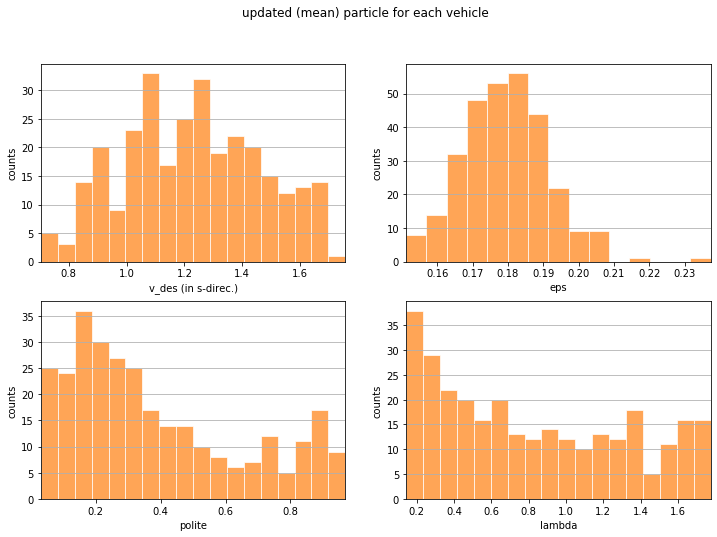

epoch 0 end.. time elapsed: 4010.6362960338593 

epoch 1 start..


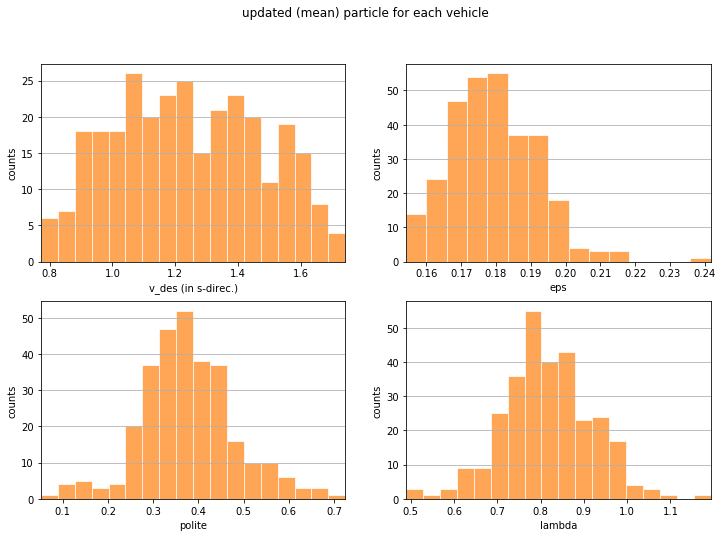

epoch 1 end.. time elapsed: 4054.4436218738556 

epoch 2 start..


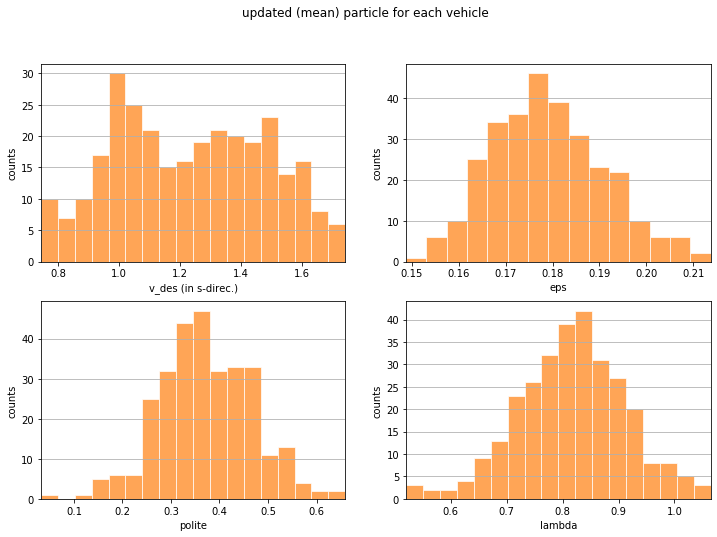

epoch 2 end.. time elapsed: 4062.9087023735046 

epoch 3 start..


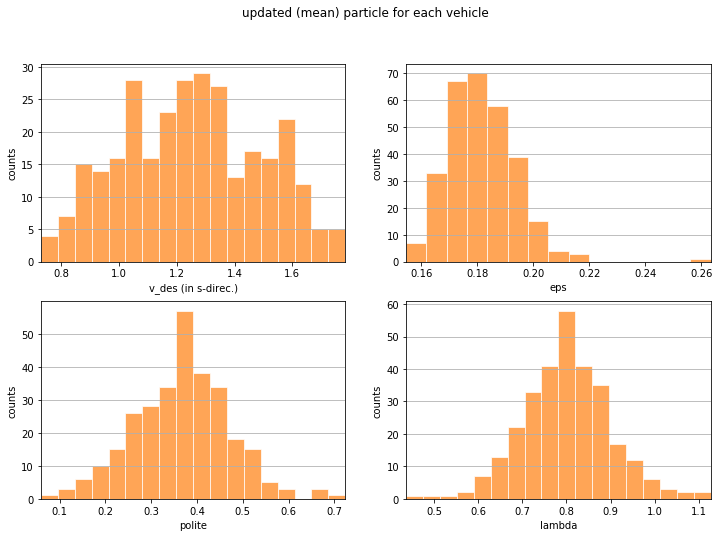

epoch 3 end.. time elapsed: 4055.0930078029633 

epoch 4 start..


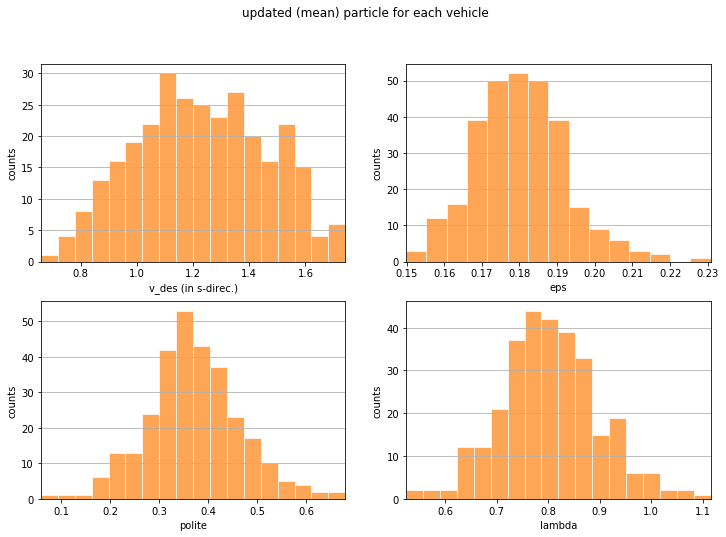

epoch 4 end.. time elapsed: 4037.7823009490967 



In [37]:
import time 

num_epoch = 5
num_p = 100
pf_noise = [0.1,0.1,0.01,0.01]

z_min, z_max = 0.5, 2.0
eps_min, eps_max = 0.1, 0.7
pol_min, pol_max = 0.0, 1.0
lam_min, lam_max = 0.1, 1.8

init_p_mat = np.random.uniform(low=[z_min,eps_min,pol_min,lam_min], \
                               high=[z_max,eps_max,pol_max,lam_max], \
                               size=(num_p,4))
print('init_p_mat', init_p_mat.shape)


lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}
p_mat_final_all_veh, p_mean_final_all_veh, _ = run_PF_plot(actual_tracks_dict_all_with_headway, lanes_rxy, num_epoch, num_p, pf_noise, \
                                                          z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max,\
                                                          init_p_mat)


epoch 0


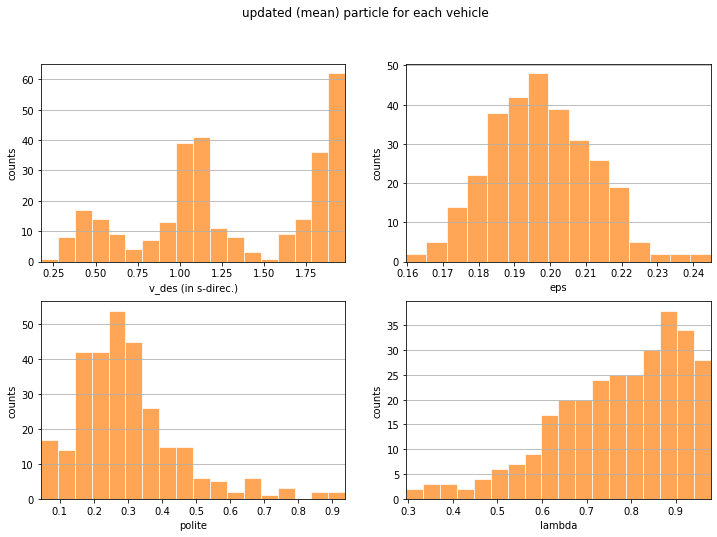

epoch 1


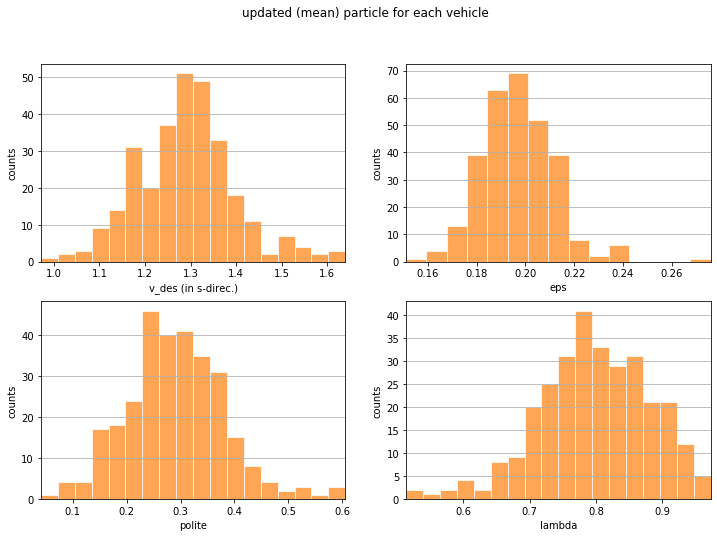

In [649]:
# import time 

# num_epoch = 5
# num_p = 100
# pf_noise = [0.1,0.1,0.01,0.01]

# z_min, z_max = 0.5, 2.0
# eps_min, eps_max = 0.1, 0.7
# pol_min, pol_max = 0.0, 1.0
# lam_min, lam_max = 0.1, 1.8

# init_p_mat = np.random.uniform(low=[z_min,eps_min,pol_min,lam_min], \
#                                high=[z_max,eps_max,pol_max,lam_max], \
#                                size=(num_p,4))
# print('init_p_mat', init_p_mat)


# lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}
# p_mat_final_all_veh, p_mean_final_all_veh, _ = run_PF_plot(actual_tracks_dict_all_with_headway, lanes_rxy, num_epoch, num_p, pf_noise, \
#                                                           z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max,\
#                                                           init_p_mat)


In [38]:
pf_idm_mobil_dict = {'p_mat_final_all_veh': p_mat_final_all_veh,
                     'p_mean_final_all_veh': p_mean_final_all_veh
                    }

# with open('PF_IDM_MOBIL_5epochs_100particles.pkl', 'wb') as file:
#     pickle.dump(pf_idm_mobil_dict, file)  
    

In [29]:
with open('PF_IDM_MOBIL_5epochs_100particles.pkl', 'rb') as file:
    pf_idm_mobil_dict = pickle.load(file)

p_mat_final_all_veh = pf_idm_mobil_dict['p_mat_final_all_veh']
p_mean_final_all_veh = pf_idm_mobil_dict['p_mean_final_all_veh']


In [27]:
def get_xy_sd_cd(sd_next_pred, xy_prev, veh_lane, lanes_rxy):
    
    ## get xy coordinates
    if lane == 'c':
        sp = sp_c
    elif lane == 'd':
        sp = sp_d
        
    lane_xi, lane_yi = sp.calc_position(sd_next_pred[0])
    if lane_xi == None:
#         print('get_sd_cd, lane_xi==None')
        return xy_prev, sd_next_pred  ##고쳐야함
    
    else:
        yawi = sp.calc_yaw(sd_next_pred[0])
        xi_ret = lane_xi + sd_next_pred[1] * math.cos(yawi + math.pi / 2.0)
        yi_ret = lane_yi + sd_next_pred[1] * math.sin(yawi + math.pi / 2.0)
        veh_xyi = np.array([xi_ret, yi_ret])


        ## s-d coordinate about lane_cd_rxy
        lane_cd_rxy = lanes_rxy['lane_cd_rxy']    
#         print('lane_cd_rxy', lane_cd_rxy.shape, 'veh_xyi', veh_xyi.shape)
#         print('veh_xyi[:,None]', veh_xyi[None,:].shape)
        if veh_xyi.shape == (2,):
            distances_cd = cdist(veh_xyi[None,:], lane_cd_rxy, 'euclidean')
        if veh_xyi.shape == (2,1):
            distances_cd = cdist(veh_xyi.reshape((1,2)), lane_cd_rxy, 'euclidean')
        veh_s_cd = lane_cd_s[np.argmin(distances_cd)]

        if np.argmin(distances_cd) == 0:
            lane_xyi_cd = lane_cd_rxy[np.argmin(distances_cd)+1, :]
            lane_xyi_prev_cd = lane_cd_rxy[np.argmin(distances_cd), :]
        else:
            lane_xyi_cd = lane_cd_rxy[np.argmin(distances_cd), :]
            lane_xyi_prev_cd = lane_cd_rxy[np.argmin(distances_cd)-1, :]
        [lane_dxi_cd, lane_dyi_cd]  = np.subtract(lane_xyi_cd, lane_xyi_prev_cd)
        [veh_dxi_cd, veh_dyi_cd] = np.subtract(veh_xyi, lane_xyi_prev_cd)
        signi_cd = np.sign(lane_dxi_cd * veh_dyi_cd - lane_dyi_cd * veh_dxi_cd)
        veh_d_cd = np.min(distances_cd) * signi_cd

    return veh_xyi, [veh_s_cd, veh_d_cd]
        

In [30]:
# def simulate_pos_bunch_pf(tracks_dict, p_mat_final_all_veh, p_mean_final_all_veh, lanes_rxy, t_0, t_end):

#     tracks_halluc_dict = dict()
# #     tracks_samples_dict = dict()
#     t_range = np.arange(t_0, t_end)
    
#     rmse_list = []
#     ll_list = []
#     M = 1 #Monte Carlo simulation for each vehiclem
    
#     for t in t_range:
#         print('\n\n t', t)
#         for veh_id, track in tracks_dict.items():
            
#             idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
            
#             if len(idx_t) == 1 and veh_id in p_mat_final_all_veh.keys():# and veh_id < 40: 
                
# #                 print('\n-----veh_id', veh_id, '-----')
                
#                 z_all_veh = p_mat_final_all_veh[veh_id][:,0]
#                 eps_all_veh = p_mat_final_all_veh[veh_id][:,1]
#                 pol_all_veh = p_mat_final_all_veh[veh_id][:,2]
#                 lam_all_veh = p_mat_final_all_veh[veh_id][:,3]
                
                
#                 if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
#                     track_0 = tracks_dict[veh_id][idx_t[0], :21]
                    
#                     tracks_halluc_dict[veh_id] = track_0[None,:]
# #                     tracks_samples_dict[veh_id] = []
#                     rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], tracks_dict[veh_id][idx_t[0], 3], veh_id, t])  #[s_true, s_pred, veh_id, t]      
                    
#                 else:   # if already exists in tracks_halluc_dict
#                     idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]
#                     veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0], 11]
# #                     print('  veh_id_hw', veh_id_hw)

#                     for m in range(M):
#                         z = np.random.choice(z_all_veh, size=1)
#                         eps = np.random.choice(eps_all_veh, size=1)
#                         pol = np.random.choice(pol_all_veh, size=1)
#                         lam = np.random.choice(lam_all_veh, size=1)
                            
#                         ### prob of changing lane
#                         prob_lane, _, veh_id_new = get_lane_change_prob(veh_id, tracks_halluc_dict[veh_id][idx_own_0[0],:], z, pol, lam, \
#                                                                         tracks_dict, p_mean_final_all_veh)
# #                         print('prob_lane', prob_lane)
                        
#                         ### samples for next 1-step
#                         if prob_lane >= 0.5:
#                             change_lane_switch = 1
                    
#                             print('\n-----veh_id', veh_id, '-----')
#                             print('\nchange lane... prob_lane:', prob_lane)
                            
#                             idx_t_real = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0] == t)[0]
# #                             print('real_v_lat', actual_tracks_dict_all_with_headway[veh_id][idx_t_real,6])
                            
                            
# #                             while change_lane_switch == 1:

#                             sd_next_pred, vsvd_next_pred, lane_pred = hallucinate_a_step_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], lanes_rxy, z)  #pd controller (lane change) 
# #                             print('sd_next_pred', sd_next_pred)
#                             xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
#                                                                          lane_pred, lanes_rxy)
                            
#                             if lane_pred != tracks_halluc_dict[veh_id][idx_own_0[0],10]:  #if lane has changed
#                                 print('lane has changed to ', lane_pred)
#                                 idx_hw_new = np.where(tracks_dict[veh_id_new][:,0] == t)[0]
#                                 dist_headway_pred = tracks_dict[veh_id_new][idx_hw_new[0], 3] - sd_next_pred[0]

#                                 track_headway_new = np.concatenate((tracks_dict[veh_id_new][idx_hw_new[0],:7],
#                                                                     [idx_hw_new[0]],
#                                                                     [dist_headway_pred],
#                                                                     [lane_pred]))
#                                 change_lane_switch = 0
                                
#                             else:
#                                 dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
#                                 track_headway_new = np.concatenate((tracks_dict[veh_id][idx_t[0], 11:19],
#                                                                     [dist_headway_pred],
#                                                                     [tracks_dict[veh_id][idx_t[0], 20]]))

#                             track_pred = np.concatenate(([t], # t
#                                                          xy_next_pred, #x,y
#                                                          sd_next_pred, vsvd_next_pred, #s,d,vs,vd
#                                                          tracks_halluc_dict[veh_id][idx_own_0[0], 7:10], #agent_type, length, width
#                                                          [lane_pred], #lane
#                                                          track_headway_new # #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx, #dist_headway #headway_lane 
#                                                          )) #s_cd, d_cd    
#                             tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
#                             print(" ====> track_pred", track_pred, '\n')
                                             
                                
#                         elif prob_lane < 0.5:
# #                             print('\nnot change lane... prob_lane:', prob_lane)
#                             sd_next_pred, vsvd_next_pred, _ = hallucinate_a_step_no_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], z)  #IDM
# #                             print('sd_next_pred', sd_next_pred)
#                             xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
#                                                                          tracks_halluc_dict[veh_id][idx_own_0[0],10], lanes_rxy)
# #                             print('xy_next_pred', xy_next_pred.shape, xy_next_pred)
#                             if xy_next_pred.shape == (2,1): 
#                                 xy_next_pred = xy_next_pred.reshape((2,))
#                             dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
                            
#                             track_pred = np.concatenate(([t], # t
#                                                          xy_next_pred, #x,y
#                                                          sd_next_pred, vsvd_next_pred, #s,d,vs,vd
#                                                          tracks_halluc_dict[veh_id][idx_own_0[0], 7:11], #agent_type, length, width, lane
#                                                          tracks_dict[veh_id][idx_t[0], 11:19], #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx
#                                                          [dist_headway_pred], #dist_headway
#                                                          [tracks_dict[veh_id][idx_t[0], 20]] #headway_lane
#                                                          )) #s_cd, d_cd                            
#                             tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
# #                             if veh_id == 595:
# #                                 print(" ====> track_pred", track_pred, '\n')
                                                        
#                         else:
#                             print('Error... prob_lane', prob_lane)
                            
# #                         print('sd_next_pred', type(sd_next_pred), len(sd_next_pred), 'tracks_dict[veh_id][idx_t[0],3:5]', type(tracks_dict[veh_id][idx_t[0],3:5]), len(tracks_dict[veh_id][idx_t[0],3:5]))
# #                         ll_list.append(multi_normal(np.array(sd_next_pred), np.diag([eps]*2)).pdf(tracks_dict[veh_id][idx_t[0],3:5]))
#                         rmse_list.append([tracks_dict[veh_id][idx_t[0], 3:5], sd_next_pred, veh_id, t])  #[sd_true, sd_pred, veh_id, t]      
                        
#     rmse_list = np.array(rmse_list)
# #     ll_list = np.array(ll_list)

    
#     tracks_xy_halluc_dict = dict()
#     for veh_id, track_halluc in tracks_halluc_dict.items():
#         veh_s, veh_d = track_halluc[:,3], track_halluc[:,4]

#         veh_x_ret, veh_y_ret = [], []
#         for i in range(len(veh_s)):
                    
#             if track_halluc[i,10] == 'c': 
#                 sp = sp_c
#             elif track_halluc[i,10] == 'd': 
#                 sp = sp_d

#             lane_xi, lane_yi = sp.calc_position(veh_s[i])
#             if lane_xi == None:
#                 terminate_i = i
#                 break

#             yawi = sp.calc_yaw(veh_s[i])
#             xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
#             yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

#             veh_x_ret.append(xi_ret)
#             veh_y_ret.append(yi_ret)

#         track_xy_ret = np.column_stack((track_halluc[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_halluc[:len(veh_x_ret),3:]))
#         tracks_xy_halluc_dict[veh_id] = track_xy_ret
# #         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id])
        
#     return tracks_xy_halluc_dict, rmse_list, ll_list


In [31]:
def simulate_pos_bunch_pf(tracks_dict, p_mat_final_all_veh, p_mean_final_all_veh, lanes_rxy, t_0, t_end):

    v_des_all_veh, eps_all_veh, pol_all_veh, lam_all_veh = dict(), dict(), dict(), dict()
    M = 1 #Monte Carlo simulation for each vehicle
    
    for veh_id, p_mat_final in p_mat_final_all_veh.items():
        
        v_des_all_veh[veh_id] = []
        eps_all_veh[veh_id] = []
        pol_all_veh[veh_id] = []
        lam_all_veh[veh_id] = []
        
        for m in range(M):
            v_des_all_veh[veh_id].append(np.random.choice(p_mat_final[:,0], size=1)[0])
            eps_all_veh[veh_id].append(np.random.choice(p_mat_final[:,1], size=1)[0])
            pol_all_veh[veh_id].append(np.random.choice(p_mat_final[:,2], size=1)[0])
            lam_all_veh[veh_id].append(np.random.choice(p_mat_final[:,3], size=1)[0])  
        print('veh_id', veh_id, 'v_des', v_des_all_veh[veh_id], 'eps', eps_all_veh[veh_id], 'pol', pol_all_veh[veh_id], 'lam', lam_all_veh[veh_id])
        
                
    tracks_halluc_dict = dict()
    change_lane_switch = dict()
#     tracks_samples_dict = dict()
    t_range = np.arange(t_0, t_end)
    
    rmse_list = []
    ll_list = []
    
    for t in t_range:
        print('\n\n t', t)
        for veh_id, track in tracks_dict.items():
            
            idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
            if len(idx_t) == 1 and veh_id in p_mat_final_all_veh.keys():
                
#                 print('\n-----veh_id', veh_id, '-----')
                
                if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
                    track_0 = tracks_dict[veh_id][idx_t[0], :21]
                    
                    tracks_halluc_dict[veh_id] = track_0[None,:]
                    change_lane_switch[veh_id] = 0
#                     tracks_samples_dict[veh_id] = []
#                     rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], tracks_dict[veh_id][idx_t[0], 3], veh_id, t])  #[s_true, s_pred, veh_id, t]      
                    rmse_list.append([tracks_dict[veh_id][idx_t[0], 1:3], tracks_dict[veh_id][idx_t[0], 1:3], veh_id, t])  #[s_true, s_pred, veh_id, t]      
                    
                else:   # if already exists in tracks_halluc_dict
                    idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]
                    veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0], 11]

                    for m in range(M):
                        v_des = v_des_all_veh[veh_id][m]
                        eps = eps_all_veh[veh_id][m]
                        pol = pol_all_veh[veh_id][m]
                        lam = lam_all_veh[veh_id][m]
                            
                        if change_lane_switch[veh_id] == 0:  ##if lane-change has not started
#                             print("\n...Lane-change switch is 0...")

                            ### prob of changing lane
                            prob_lane, _, veh_id_new = get_lane_change_prob(veh_id, tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des, pol, lam, \
                                                                        tracks_dict, p_mean_final_all_veh)
#                             prob_lane, _, veh_id_new = get_lane_change_prob_EM(veh_id, tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des, pol, lam, \
#                                                                                tracks_dict, mle_probs_final_all_veh, params_range)
#                             print('prob_lane', prob_lane)


                            ### samples for next 1-step
                            if prob_lane >= 0.5:
                                print('\n-----veh_id', veh_id, '-----')
                                print("...Lane-change switch was 0... => initiated lane-change, prob_lane", prob_lane)
                                change_lane_switch[veh_id] = 1

                                idx_t_real = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0] == t)[0]
    #                             print('real_v_lat', actual_tracks_dict_all_with_headway[veh_id][idx_t_real,6])

                                sd_next_pred, vsvd_next_pred, lane_pred = hallucinate_a_step_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], lanes_rxy, v_des)  #pd controller (lane change) 
                                xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3], lane_pred, lanes_rxy)
#                                 print('lane_pred', lane_pred)

                                if lane_pred != tracks_halluc_dict[veh_id][idx_own_0[0],10]:  ##if lane has changed 
                                    print(' Lane has changed to ', lane_pred)
                                    idx_hw_new = np.where(tracks_dict[veh_id_new][:,0] == t)[0]
                                    dist_headway_pred = tracks_dict[veh_id_new][idx_hw_new[0], 3] - sd_next_pred[0]

                                    track_headway_new = np.concatenate((tracks_dict[veh_id_new][idx_hw_new[0],:7],
                                                                        [idx_hw_new[0]],
                                                                        [dist_headway_pred],
                                                                        [lane_pred]))
                        
                                    if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
                                        change_lane_switch[veh_id] = 0
                                    else:                               ##if lane has changed but haven't merged into new lane yet 
                                        change_lane_switch[veh_id] = 2
                                    
                            
                                else:  ##if lane has not changed yet (still in the process of lane-changing)
                                    dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
                                    track_headway_new = np.concatenate((tracks_dict[veh_id][idx_t[0], 11:19],
                                                                        [dist_headway_pred],
                                                                        [tracks_dict[veh_id][idx_t[0], 20]]))
                                    change_lane_switch[veh_id] = 1

                                track_pred = np.concatenate(([t], # t
                                                             xy_next_pred, #x,y
                                                             sd_next_pred, vsvd_next_pred, #s,d,vs,vd
                                                             tracks_halluc_dict[veh_id][idx_own_0[0], 7:10], #agent_type, length, width
                                                             [lane_pred], #lane
                                                             track_headway_new # #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx, #dist_headway #headway_lane 
                                                             )) #s_cd, d_cd    
                                tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
#                                 print(" ====> track_pred", track_pred, '\n')


                            elif prob_lane < 0.5:
                                change_lane_switch[veh_id] = 0
                                
    #                             print('\nnot change lane... prob_lane:', prob_lane)
                                sd_next_pred, vsvd_next_pred, _ = hallucinate_a_step_no_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des)  #IDM
    #                             print('sd_next_pred', sd_next_pred)
                                xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
                                                                             tracks_halluc_dict[veh_id][idx_own_0[0],10], lanes_rxy)
    #                             print('xy_next_pred', xy_next_pred.shape, xy_next_pred)
                                if xy_next_pred.shape == (2,1): 
                                    xy_next_pred = xy_next_pred.reshape((2,))
                                dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]

                                track_pred = np.concatenate(([t], # t
                                                             xy_next_pred, #x,y
                                                             sd_next_pred, vsvd_next_pred, #s,d,vs,vd
                                                             tracks_halluc_dict[veh_id][idx_own_0[0], 7:11], #agent_type, length, width, lane
                                                             tracks_dict[veh_id][idx_t[0], 11:19], #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx
                                                             [dist_headway_pred], #dist_headway
                                                             [tracks_dict[veh_id][idx_t[0], 20]] #headway_lane
                                                             )) #s_cd, d_cd                            
                                tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 

                            else:
                                print('Error... prob_lane', prob_lane)

                                
                        elif change_lane_switch[veh_id] == 1:  ##if lane-change has started and not finished
                            print('\n-----veh_id', veh_id, '-----')
                            print("...Lane-change switch is 1...")
                            
                            idx_t_real = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0] == t)[0]
#                             print('real_v_lat', actual_tracks_dict_all_with_headway[veh_id][idx_t_real,6])

                            sd_next_pred, vsvd_next_pred, lane_pred = hallucinate_a_step_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], lanes_rxy, v_des)  #pd controller (lane change) 
                            xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3], lane_pred, lanes_rxy)

                            if lane_pred != tracks_halluc_dict[veh_id][idx_own_0[0],10]: ##if lane has changed 
                                print(' Lane has changed to ', lane_pred)
                                idx_hw_new = np.where(tracks_dict[veh_id_new][:,0] == t)[0]
                                dist_headway_pred = tracks_dict[veh_id_new][idx_hw_new[0], 3] - sd_next_pred[0]

                                track_headway_new = np.concatenate((tracks_dict[veh_id_new][idx_hw_new[0],:7],
                                                                    [idx_hw_new[0]],
                                                                    [dist_headway_pred],
                                                                    [lane_pred]))
                                
                                if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
                                    change_lane_switch[veh_id] = 0
                                else:                               ##if lane has changed but haven't merged into new lane yet 
                                    change_lane_switch[veh_id] = 2

                            else:  ##if lane has not changed yet (still in the process of lane-changing)
                                dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
                                track_headway_new = np.concatenate((tracks_dict[veh_id][idx_t[0], 11:19],
                                                                    [dist_headway_pred],
                                                                    [tracks_dict[veh_id][idx_t[0], 20]]))
                                change_lane_switch[veh_id] = 1

                            track_pred = np.concatenate(([t], # t
                                                         xy_next_pred, #x,y
                                                         sd_next_pred, vsvd_next_pred, #s,d,vs,vd
                                                         tracks_halluc_dict[veh_id][idx_own_0[0], 7:10], #agent_type, length, width
                                                         [lane_pred], #lane
                                                         track_headway_new # #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx, #dist_headway #headway_lane 
                                                         )) #s_cd, d_cd    
                            tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
#                             print(" ====> track_pred", track_pred, '\n')
                               

                        elif change_lane_switch[veh_id] == 2:  ##if lane-change has changed but haven't merged into new lane yet 
                            print('\n-----veh_id', veh_id, '-----')
                            print("...Lane-change switch was 2...")
                    
                            track_i = tracks_halluc_dict[veh_id][idx_own_0[0],:]

                            if track_i[10] == 'c': 
                                offset = track_i[4] # - min_dist_bet_lanes 
                            elif track_i[10] == 'd': 
                                offset = track_i[4] #+ min_dist_bet_lanes 
                            print('track_i[4]', track_i[4], 'track_i[6]', track_i[6], 'track_i[10]', track_i[10], 'offset', offset)
                            
                            a_lat_pred = - offset * 0.02 
                            v_lat_pred = track_i[6] + a_lat_pred
                            s_lat_pred = track_i[4] + track_i[6] + 0.5 * a_lat_pred
                            print('s_lat_pred', s_lat_pred)
                              
                            sd_next_pred_idm, vsvd_next_pred_idm, _ = hallucinate_a_step_no_change(track_i, v_des)   
                            sd_next_pred = [sd_next_pred_idm[0], s_lat_pred]
                            vsvd_next_pred = [vsvd_next_pred_idm[0], v_lat_pred]
                            
                            xy_next_pred, _ = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
                                                                         tracks_halluc_dict[veh_id][idx_own_0[0],10], lanes_rxy)
                            if xy_next_pred.shape == (2,1): 
                                xy_next_pred = xy_next_pred.reshape((2,))
                            dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]

                            track_pred = np.concatenate(([t], # t
                                                         xy_next_pred, #x,y
                                                         sd_next_pred, vsvd_next_pred, #s,d,vs,vd
                                                         tracks_halluc_dict[veh_id][idx_own_0[0], 7:11], #agent_type, length, width, lane
                                                         tracks_dict[veh_id][idx_t[0], 11:19], #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx
                                                         [dist_headway_pred], #dist_headway
                                                         [tracks_dict[veh_id][idx_t[0], 20]] #headway_lane
                                                         )) #s_cd, d_cd                            
                            tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
                            
                            if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
                                change_lane_switch[veh_id] = 0
                            else:                               ##if lane has changed but haven't merged into new lane yet 
                                change_lane_switch[veh_id] = 2
                            
#                         print('sd_next_pred', type(sd_next_pred), len(sd_next_pred), 'tracks_dict[veh_id][idx_t[0],3:5]', type(tracks_dict[veh_id][idx_t[0],3:5]), len(tracks_dict[veh_id][idx_t[0],3:5]))
#                         ll_list.append(multi_normal(np.array(sd_next_pred), np.diag([eps]*2)).pdf(tracks_dict[veh_id][idx_t[0],3:5]))
#                         rmse_list.append([tracks_dict[veh_id][idx_t[0], 3:5], sd_next_pred, veh_id, t])  #[sd_true, sd_pred, veh_id, t]      
                        rmse_list.append([tracks_dict[veh_id][idx_t[0], 1:3], xy_next_pred, veh_id, t])  #[sd_true, sd_pred, veh_id, t]      

        
    rmse_list = np.array(rmse_list)
#     ll_list = np.array(ll_list)

    
    tracks_xy_halluc_dict = dict()
    for veh_id, track_halluc in tracks_halluc_dict.items():
        veh_s, veh_d = track_halluc[:,3], track_halluc[:,4]

        veh_x_ret, veh_y_ret = [], []
        for i in range(len(veh_s)):
                    
            if track_halluc[i,10] == 'c': 
                sp = sp_c
            elif track_halluc[i,10] == 'd': 
                sp = sp_d

            lane_xi, lane_yi = sp.calc_position(veh_s[i])
            if lane_xi == None:
                terminate_i = i
                break

            yawi = sp.calc_yaw(veh_s[i])
            xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
            yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

            veh_x_ret.append(xi_ret)
            veh_y_ret.append(yi_ret)

        track_xy_ret = np.column_stack((track_halluc[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_halluc[:len(veh_x_ret),3:]))
        tracks_xy_halluc_dict[veh_id] = track_xy_ret
#         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id])
        
    return tracks_xy_halluc_dict, rmse_list, ll_list


In [32]:
t_0 = 1000
t_end = 1450

p_mat_final_all_veh_filtered = dict()
for veh_id, p_mat_final in p_mat_final_all_veh.items():
    if veh_id > 201 and veh_id < 210:
        p_mat_final_all_veh_filtered[veh_id] = p_mat_final

tracks_xy_halluc_dict_pf, rmse_list_pf, ll_list_pf = simulate_pos_bunch_pf(
    actual_tracks_dict_all_with_headway, p_mat_final_all_veh_filtered, p_mean_final_all_veh, lanes_rxy, t_0, t_end)


veh_id 203 v_des [1.854275657432575] eps [0.28867901770356663] pol [0.24796353788186104] lam [0.9065752863929409]
veh_id 204 v_des [1.7266966207157812] eps [0.11432889821548685] pol [0.42308683581850365] lam [0.6998442303549488]
veh_id 206 v_des [0.9173814816191671] eps [0.1] pol [0.4276544730263655] lam [0.9947503450101028]
veh_id 207 v_des [1.8856982738145522] eps [0.1] pol [0.4568626488638582] lam [0.7081638035183399]
veh_id 208 v_des [0.7906365189149955] eps [0.1] pol [0.14671208960028992] lam [0.8313857007683015]


 t 1000


 t 1001


 t 1002


 t 1003


 t 1004


 t 1005


 t 1006


 t 1007


 t 1008


 t 1009


 t 1010


 t 1011


 t 1012


 t 1013


 t 1014


 t 1015


 t 1016


 t 1017


 t 1018


 t 1019


 t 1020


 t 1021


 t 1022


 t 1023


 t 1024


 t 1025


 t 1026


 t 1027


 t 1028


 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044


 t 1045


 t 1046


 t 1

 t 1123

-----veh_id 204 -----
...Lane-change switch was 2...
track_i[4] -1.6875481439490618 track_i[6] -1.1273520521463816 track_i[10] d offset -1.6875481439490618
s_lat_pred -2.798024714655953


 t 1124

-----veh_id 204 -----
...Lane-change switch was 2...
track_i[4] -2.798024714655953 track_i[6] -1.0936010892674004 track_i[10] d offset -2.798024714655953
s_lat_pred -3.8636455567767936


 t 1125

-----veh_id 204 -----
...Lane-change switch was 2...
track_i[4] -3.8636455567767936 track_i[6] -1.0376405949742813 track_i[10] d offset -3.8636455567767936
s_lat_pred -4.862649696183307


 t 1126

-----veh_id 204 -----
...Lane-change switch was 2...
track_i[4] -4.862649696183307 track_i[6] -0.9603676838387454 track_i[10] d offset -4.862649696183307
s_lat_pred -5.774390883060219


 t 1127

-----veh_id 204 -----
...Lane-change switch was 2...
track_i[4] -5.774390883060219 track_i[6] -0.8631146899150792 track_i[10] d offset -5.774390883060219
s_lat_pred -6.579761664144696


 t 1128

-----veh_id

 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181


 t 1182


 t 1183


 t 1184


 t 1185


 t 1186


 t 1187


 t 1188


 t 1189


 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272




In [34]:
animate_in_xy_simulate(tracks_xy_halluc_dict_pf, actual_tracks_dict_all_with_headway, t_0, t_end)


interactive(children=(IntSlider(value=1225, description='t', max=1450, min=1000), Output(layout=Layout(height=…

In [1040]:
# animate_in_xy(actual_tracks_dict_all_with_headway, t_0, t_end)


interactive(children=(IntSlider(value=3050, description='t', max=3150, min=2950, step=10), Output(layout=Layou…

In [1038]:
# t_0 = 2950 #actual_tracks_dict_idm_with_headway[0][0, 0]
# t_end = 3150 #actual_tracks_dict_idm_with_headway[128][-1, 0]

# tracks_xy_halluc_dict_pf, rmse_list_pf, ll_list_pf = simulate_pos_bunch(
#     actual_tracks_dict_all_with_headway, p_mat_final_all_veh, p_mean_final_all_veh, lanes_rxy, t_0, t_end)




 t 2950


 t 2951


 t 2952


 t 2953


 t 2954


 t 2955


 t 2956


 t 2957


 t 2958


 t 2959


 t 2960


 t 2961


 t 2962


 t 2963


 t 2964


 t 2965


 t 2966


 t 2967


 t 2968


 t 2969


 t 2970


 t 2971


 t 2972


 t 2973


 t 2974


 t 2975


 t 2976


 t 2977


 t 2978


 t 2979


 t 2980

-----veh_id 567 -----

change lane... prob_lane: [0.51881086]
 ====> track_pred [2980 1048.4031140863106 951.3475855405064 98.73840164612042
 0.6401769550456793 0.3387578620999565 0.04555888903684338 'car' 3.59 1.62
 'c' 564 1045.982 955.698 100.86515344026222 0.7308432548153686
 0.11956159838821634 0.0004074954373549655 156 2.1267517941417964 'c'] 



 t 2981

-----veh_id 567 -----

change lane... prob_lane: [0.51913444]
 ====> track_pred [2981 1048.1084631996207 951.3086246896464 99.02715950822038
 0.7074757163905917 0.3387578620999565 0.08903863365298154 'car' 3.59 1.62
 'c' 564 1045.856 955.711 100.99966023844897 0.7311486332814322
 0.1345067981867487 0.0003053784660635994 157

-----veh_id 570 -----

change lane... prob_lane: [0.51271036]
 ====> track_pred [2997 1047.943323586712 948.928572143683 98.9606202787436
 3.0923089983952203 0.5380271927469916 0.1551790643374711 'car' 4.5 1.77
 'c' 567 1050.79 955.285 96.05279910513636 0.6818630232482433
 0.10461639858969818 0.0005496029016529569 157 -2.907821173607246 'c'] 



 t 2998

-----veh_id 567 -----

change lane... prob_lane: [0.51614236]
 ====> track_pred [2998 1042.8613136320116 948.8087025326375 103.93604316391963
 3.7528236380871984 0.3387578620999565 -0.042778665143054506 'car' 3.59
 1.62 'c' 564 1043.792 955.928 103.06209781064577 0.7403242647902281
 0.1345067981867487 0.000517994158141577 174 -0.8739453532738679 'c'] 


-----veh_id 570 -----

change lane... prob_lane: [0.52138864]
 ====> track_pred [2998 1047.4380824942423 948.8375205278631 99.4486474714906
 3.2324412627255508 0.5380271927469916 0.12508546432318937 'car' 4.5 1.77
 'c' 567 1050.6789999999999 955.295 96.17236070352457 0.6815866874810371


 ====> track_pred [3011 1063.3521532183547 950.7604748817237 83.80582994743338
 0.20357187364603385 1.0483315814628453 -0.08158028705642387 'car' 4.53
 1.81 'd' 575 1061.5339999999999 950.013 85.59201007694735
 1.030412364559366 0.54172158276549 0.0060442161018499085 109
 1.7861801295139657 'd'] 


-----veh_id 587 -----

change lane... prob_lane: [0.51704033]
 ====> track_pred [3011 1077.331185523409 949.7889743134637 69.84102780802185
 0.9581326772123568 0.8485552330052846 0.08658079672379954 'car' 4.26 1.71
 'c' 578 1074.761 954.58 72.11058902789527 0.3434394567674394
 0.3736299949631814 0.005141264426323122 96 2.269561219873424 'c'] 


-----veh_id 590 -----

change lane... prob_lane: [0.51255151]
 ====> track_pred [3011 1082.7907315313441 953.9017223243565 64.2828684996748
 -3.0489224721824315 1.0533475220440067 -0.43412319464308247 'car' 4.04
 1.52 'd' 586 1079.366 950.582 67.80548477614711 0.19183056457683548
 0.616960691482916 0.0092324456511709 68 3.5226162764723057 'd'] 



 t 

-----veh_id 574 -----

change lane... prob_lane: [0.51822405]
 ====> track_pred [3018 1051.0310525101615 951.4947625482907 96.13928210062132
 0.2535323636313712 0.6011291474518856 0.11905743035880224 'car' 4.34 1.74
 'c' 570 1057.039 954.577 89.79076038955333 0.9174066659937059
 0.1345067981867487 0.001081615581300932 142 -6.348521711067988 'c'] 


-----veh_id 587 -----

change lane... prob_lane: [0.51869332]
 ====> track_pred [3018 1071.709201584339 948.5388582099307 75.43091443905887
 2.2109923610660145 0.8485552330052846 0.23013607903292235 'car' 4.26 1.71
 'c' 578 1072.613 954.569 74.26269779888324 0.3646715666398277
 0.25406839657496505 0.0020530279731112433 103 -1.168216640175629 'c'] 


-----veh_id 590 -----

change lane... prob_lane: [0.51313423]
 ====> track_pred [3018 1075.840451671305 954.5902689628217 71.30630115398287
 -3.853296759509933 1.0533475220440067 -0.3640319439429334 'car' 4.04 1.52
 'd' 586 1075.261 950.453 71.89849229037526 0.28212931085075094
 0.571817226252463


-----veh_id 567 -----

change lane... prob_lane: [0.51880964]
 ====> track_pred [3026 1035.1333367541952 952.6003863386641 112.02126330271841
 1.0095910119642306 0.3387578620999565 0.2876964178963626 'car' 3.59 1.62
 'c' 564 1036.857 956.83 110.04150611655811 0.7191374422058039
 0.38857519476171376 -0.0050046658249924825 202 -1.979757186160299 'c'] 


-----veh_id 570 -----

change lane... prob_lane: [0.52083078]
 ====> track_pred [3026 1034.0246613119414 952.6039497035507 113.11340886840654
 1.1714004041741062 0.5380271927469916 0.22636745018458437 'car' 4.5 1.77
 'c' 567 1046.231 955.632 100.61108504368725 0.7705499471962733
 0.20923279717939636 0.006387232447725877 186 -12.502323824719284 'c'] 


-----veh_id 574 -----

change lane... prob_lane: [0.52465872]
 ====> track_pred [3026 1046.403748561265 949.6558003279868 100.54831528023642
 2.5228246603766404 0.6011291474518856 0.36102992692931635 'car' 4.34 1.74
 'c' 570 1055.856 954.65 90.971431173637 0.9226325107851069
 0.164397197783

-----veh_id 570 -----

change lane... prob_lane: [0.51191698]
 ====> track_pred [3031 1031.385759205339 951.6503559596619 115.55354483214153
 2.52494464063105 0.5380271927469916 0.2827972624108496 'car' 4.5 1.77 'c'
 567 1045.0430000000001 955.7280000000001 101.80670102756945
 0.8009102304617839 0.25406839657496505 0.00546830244383445 191
 -13.74684380457208 'c'] 


-----veh_id 574 -----

change lane... prob_lane: [0.52324807]
 ====> track_pred [3031 1043.4688800525066 948.4780937487078 103.30396101749587
 4.011525004195619 0.6011291474518856 0.19624396609232517 'car' 4.34 1.74
 'c' 570 1054.9160000000002 954.712 91.91297876094423 0.9264556626653726
 0.20923279717938215 0.0005702588825426957 155 -11.390982256551638 'c'] 


-----veh_id 578 -----

change lane... prob_lane: [0.51946079]
 ====> track_pred [3031 1045.3621475082925 950.5974643989107 101.67416741810142
 1.695988981319503 0.7854532783003907 0.31571916008723805 'car' 4.53 1.78
 'c' 574 1063.657 954.345 83.18498207860416 0.80549

-----veh_id 587 -----

change lane... prob_lane: [0.51790895]
 ====> track_pred [3036 1057.2425484512155 949.2580677078763 89.80490863315406
 2.0205077876222384 0.8485552330052846 -0.26326999408317897 'car' 4.26
 1.71 'c' 578 1069.856 954.585 77.0126145618123 0.38534659991077563
 0.11956159838821634 0.0009296103342213979 121 -12.792294071341757 'c'] 


-----veh_id 593 -----

change lane... prob_lane: [0.51846022]
 ====> track_pred [3036 1075.7278904206655 953.4798689192963 71.42475055213691
 -2.7433621158525328 0.9931562350700638 -0.49971112122175915 'car' 4.72
 1.77 'd' 590 1075.738 950.505 71.4320098163272 0.23159984252564286
 0.5718172262524632 -0.006696806266888816 78 0.007259264190281556 'd'] 


-----veh_id 596 -----

change lane... prob_lane: [0.51599254]
 ====> track_pred [3036 1091.4306147823172 951.1737593968307 55.72614893453775
 0.055650699170080295 1.0232518785570353 -0.07720667654961604 'car' 4.25
 1.67 'd' 593 1087.91 950.368 59.27336984759065 0.6755130237579624
 0.556769

-----veh_id 593 -----

change lane... prob_lane: [0.51285542]
 ====> track_pred [3041 1071.081090189007 955.2439659847704 76.14053172748723
 -4.486291916293661 0.9931562350700638 -0.3373908540203481 'car' 4.72 1.77
 'd' 590 1072.933 950.528 74.23090466061555 0.21176235875426047
 0.5567694045089695 -0.00212356442944317 83 -1.9096270668716784 'd'] 


-----veh_id 595 -----

change lane... prob_lane: [0.51843074]
 ====> track_pred [3041 1092.8890446756436 950.1001288687725 54.338910613797744
 1.2162072056596376 0.7472599899263752 0.10205510642910784 'car' 4.68 1.82
 'c' 591 1090.8210000000001 955.419 56.04449924447819 -0.06947451746472619
 0.403520394560239 0.0005926070735562117 80 1.7055886306804453 'c'] 


-----veh_id 596 -----

change lane... prob_lane: [0.52338668]
 ====> track_pred [3041 1086.5228426075835 952.0461746602265 60.59240832732293
 -1.062254961897302 1.0232518785570353 -0.34634220795260034 'car' 4.25
 1.67 'd' 593 1085.115 950.26 62.07226469187901 0.6672485343977005
 0.5567

change lane... prob_lane: [0.51653313]
 ====> track_pred [3048 1079.69061083885 954.4976617984544 67.40517147722218
 -3.717679712018462 1.0232518785570353 -0.3190328049099707 'car' 4.25 1.67
 'd' 593 1081.098 950.148 66.07498527564624 0.6597997138851722
 0.5718172262524632 0.00018478344714567552 72 -1.3301862015759411 'd'] 



 t 3049

-----veh_id 570 -----

change lane... prob_lane: [0.51888508]
 ====> track_pred [3049 1022.4081752107567 951.9885268148586 124.33803430158748
 3.789438756299126 0.5380271927469916 -0.06959793462663494 'car' 4.5 1.77
 'c' 567 1038.796 956.435 108.06873974315248 0.8478950469492789
 0.44835599395582904 -0.0020648946226113907 209 -16.269294558435007 'c'] 


-----veh_id 587 -----

change lane... prob_lane: [0.51772861]
 ====> track_pred [3049 1046.939003480062 951.2957052055241 100.1861266622228
 0.8367274757115272 0.8485552330052846 0.1813530930253996 'car' 4.26 1.71
 'c' 578 1068.519 954.602 78.34273734388125 0.39576972528509335
 0.10461639858969818 0.00141

-----veh_id 587 -----

change lane... prob_lane: [0.51869332]
 ====> track_pred [3055 1041.9731278658992 950.2649415904775 104.97745806025453
 2.411507370148368 0.8485552330052846 0.29849143030688374 'car' 4.26 1.71
 'c' 578 1067.763 954.6160000000001 79.10494253360615 0.4000602648716116
 0.14945199798526687 0.0006508814528762286 140 -25.872515526648385 'c'] 


-----veh_id 591 -----

change lane... prob_lane: [0.51000714]
 ====> track_pred [3055 1057.1308440584842 947.1457835555597 89.78395198290468
 4.1356373217535785 0.8668215883145951 0.03665454251258411 'car' 4.55 1.74
 'c' 587 1076.385 953.198 70.4965074496543 1.7283420001634897
 0.17934239758233161 0.021118108236346078 112 -19.28744453325038 'c'] 


-----veh_id 596 -----

change lane... prob_lane: [0.51984509]
 ====> track_pred [3055 1072.9724387231952 955.1857012895654 74.21793462712144
 -4.4461027768072166 1.0232518785570353 0.14459075911946756 'car' 4.25
 1.67 'd' 593 1076.993 950.0830000000001 70.18304061161787
 0.66116125434

 t 3061

-----veh_id 570 -----

change lane... prob_lane: [0.51186906]
 ====> track_pred [3061 1017.1479959289189 955.7091667601238 130.19436061455139
 1.2363256837098768 0.5380271927469916 -0.31576163877240604 'car' 4.5 1.77
 'c' 567 1032.645 957.3530000000001 114.2709976595414 0.8219824636719085
 0.5828627921425635 -0.002844196066209892 221 -15.923362955009992 'c'] 


-----veh_id 586 -----

change lane... prob_lane: [0.51601547]
 ====> track_pred [3061 1014.7842287066367 961.0745423738971 133.7224090205757
 -3.458553753629668 1.0483315814628453 -0.37448922647767335 'car' 4.53
 1.81 'd' 575 1026.47 954.1419999999999 120.78886513496069
 0.9101400776342375 0.7674389089177822 -0.008696331452742512 159
 -12.93354388561501 'd'] 


-----veh_id 587 -----

change lane... prob_lane: [0.51857198]
 ====> track_pred [3061 1036.9862134576142 949.5186819205792 109.76878945828626
 3.7954654244798105 0.8485552330052846 0.11887081049384522 'car' 4.26 1.71
 'c' 578 1066.685 954.64 80.18099691910014 0.4

-----veh_id 570 -----

change lane... prob_lane: [0.51916298]
 ====> track_pred [3066 1015.020922881567 957.3817094183875 132.6344965782863
 0.08063710830158141 0.5380271927469916 -0.11621680561987882 'car' 4.5
 1.77 'c' 567 1029.673 957.86 117.27498281904543 0.8003775414761587
 0.6127531917396283 -0.00593568126482491 226 -15.359513759240869 'c'] 


-----veh_id 587 -----

change lane... prob_lane: [0.52192802]
 ====> track_pred [3066 1032.989603108971 950.1870100726558 113.7615656233127
 3.7179169487200587 0.8485552330052846 -0.15150280522699075 'car' 4.26
 1.71 'c' 578 1065.461 954.677 81.4065033025794 0.40724559906084395
 0.2690135963734974 -2.5814863710227343e-05 151 -32.35506232073331 'c'] 


-----veh_id 593 -----

change lane... prob_lane: [0.51708671]
 ====> track_pred [3066 1047.4755604893971 951.9529556846051 99.7194376042388
 0.128721424772385 0.9931562350700638 0.46901787767811326 'car' 4.72 1.77
 'd' 590 1057.704 950.8839999999999 89.44425244327972 0.3690354531870058
 0.7072

-----veh_id 570 -----

change lane... prob_lane: [0.51346056]
 ====> track_pred [3074 1011.2225966941703 958.2907613207643 136.53871412026217
 0.09290502524954138 0.5380271927469916 0.12414261184173225 'car' 4.5 1.77
 'c' 567 1024.776 958.829 122.2517343519551 0.7109491276149835
 0.6127531917396283 -0.015070347596179978 234 -14.286979768307077 'c'] 


-----veh_id 587 -----

change lane... prob_lane: [0.52277741]
 ====> track_pred [3074 1027.0103922389899 953.5378824688605 120.15000748735501
 1.40717284041354 0.8485552330052846 -0.3367980114596195 'car' 4.26 1.71
 'c' 593 1065.864 950.24 81.27328523656692 0.6328908893619699
 0.616960691482916 -0.0021689635303041577 98 -38.87672225078809 'd'] 


-----veh_id 596 -----

change lane... prob_lane: [0.52070182]
 ====> track_pred [3074 1054.4177750996641 950.7450998411025 92.70972031970513
 0.7296935847153858 1.0232518785570353 -0.06402570088974814 'car' 4.25
 1.67 'd' 587 1072.175 952.515 74.99834356953333 -1.7694871748678855
 0.3160042566131

 t 3082

-----veh_id 587 -----

change lane... prob_lane: [0.5227891]
 ====> track_pred [3082 1021.0076262561435 956.2218599683722 126.53844935139732
 -0.07948003278294363 0.8485552330052846 0.03255841724660499 'car' 4.26
 1.71 'c' 593 1060.503 950.455 86.63030977724787 0.6396808305358354
 0.7072476219438357 0.0037126490490997366 106 -39.908139574149445 'd'] 


-----veh_id 591 -----

change lane... prob_lane: [0.51157203]
 ====> track_pred [3082 1035.0784510585268 950.9726365338538 111.83813486739878
 2.6277898472964183 0.8668215883145951 -0.3617325366902676 'car' 4.55 1.74
 'c' 578 1059.435 954.954 87.42941882138598 0.3983955505878203
 0.4633011937543472 -0.0011068378112584765 167 -24.4087160460128 'c'] 


-----veh_id 593 -----

change lane... prob_lane: [0.5176404]
 ====> track_pred [3082 1032.4730840792413 953.6949886984909 114.80993736535981
 0.3332304410612002 0.9931562350700638 -0.46290227504259207 'car' 4.72
 1.77 'd' 590 1044.942 951.8 102.21985310349918 0.546080454600122
 0.85

-----veh_id 593 -----

change lane... prob_lane: [0.518757]
 ====> track_pred [3090 1025.9325021764516 959.723598802448 122.35518724592032
 -4.476900652441154 0.9931562350700638 -0.5454055599082482 'car' 4.72 1.77
 'd' 590 1037.923 952.705 109.27728150119403 0.5106899610816484
 0.887821482865661 -0.00996340267582474 132 -13.077905744726294 'd'] 


-----veh_id 596 -----

change lane... prob_lane: [0.52441421]
 ====> track_pred [3090 1039.6797144831326 958.2729161673052 108.28175037661771
 -5.242970787648424 1.0232518785570353 -0.1365506141769516 'car' 4.25 1.67
 'd' 587 1065.025 951.582 82.16110671943258 -0.6805802730775399
 0.5567694045089695 0.0597893663854675 147 -26.120643657185127 'd'] 


-----veh_id 606 -----

change lane... prob_lane: [0.51188177]
 ====> track_pred [3090 1086.329364862023 950.581989532235 60.846635893695066
 0.39266437134510596 0.8577258393786913 -0.17116801339855664 'car' 4.82
 1.82 'd' 601 1083.3519999999999 950.482 63.81781201412337
 0.3860323756515851 0.52667

-----veh_id 596 -----

change lane... prob_lane: [0.52313933]
 ====> track_pred [3097 1032.8644388497216 957.9190186483402 115.09451352651696
 -3.8994687631759932 1.0232518785570353 0.48487132142752337 'car' 4.25
 1.67 'd' 587 1060.849 951.398 86.32935334237816 -0.319694273559322
 0.616960691482916 0.04623149472742727 154 -28.765160184138807 'd'] 


-----veh_id 607 -----

change lane... prob_lane: [0.51203792]
 ====> track_pred [3097 1096.6169973155004 951.1358064721029 50.55844821735708
 0.4431333720665369 0.6127531917396283 0.14879228631650895 'car' 4.52 1.68
 'c' 599 1095.06 955.068 51.82995290129343 0.5381322277382203
 0.3736299949631885 -0.00868297304214094 94 1.2715046839363495 'c'] 



 t 3098

-----veh_id 593 -----

change lane... prob_lane: [0.52056946]
 ====> track_pred [3098 1018.9436123063196 962.4206692474205 129.90043712648082
 -5.705121824154592 0.9931562350700638 0.30689290995624685 'car' 4.72 1.77
 'd' 590 1030.9460000000001 953.8939999999999 116.34975772063237
 0.3823

-----veh_id 606 -----

change lane... prob_lane: [0.52371794]
 ====> track_pred [3104 1075.0038120636916 954.4037356648329 72.15479764499673
 -3.6690699843913746 0.8577258393786913 -0.4377882246924488 'car' 4.82
 1.82 'd' 601 1076.489 950.365 70.6796187291529 0.37541612375031813
 0.466482474048064 -0.005385089033147383 92 -1.475178915843827 'd'] 


-----veh_id 607 -----

change lane... prob_lane: [0.51229785]
 ====> track_pred [3104 1092.7605587666817 949.6026801965198 54.4977205595345
 1.7045622637512017 0.6127531917396283 0.32758897382642554 'car' 4.52 1.68
 'c' 599 1092.35 954.936 54.54997926462544 0.49877035768765715
 0.40352039456024613 -0.0037946187527014286 101 0.052258705090942215 'c'] 



 t 3105

-----veh_id 596 -----

change lane... prob_lane: [0.52489396]
 ====> track_pred [3105 1024.4688829247646 954.8595403138285 122.88052855497325
 0.5757802734208751 1.0232518785570353 0.452271399186714 'car' 4.25 1.67
 'd' 587 1055.759 951.3639999999999 91.41551709167636 0.0169700538999



 t 3113

-----veh_id 595 -----

change lane... prob_lane: [0.51850729]
 ====> track_pred [3113 1042.3102105471812 949.3758663057849 104.54162988849708
 3.254106381801024 0.7472599899263752 0.029550684296050178 'car' 4.68 1.82
 'c' 591 1062.127 955.1260000000001 84.75422805744955 0.09103965164941559
 0.6276983915381606 0.011491691143094687 152 -19.787401831047532 'c'] 


-----veh_id 596 -----

change lane... prob_lane: [0.52494581]
 ====> track_pred [3113 1016.7173189968838 955.9564732832564 130.6665435834295
 1.0894625729149972 1.0232518785570353 -0.36087618564269347 'car' 4.25
 1.67 'd' 587 1050.432 951.5160000000001 96.74244598887034
 0.28489577669837224 0.692199800200342 0.02705073221950466 170
 -33.92409759455916 'd'] 


-----veh_id 599 -----

change lane... prob_lane: [0.5150943]
 ====> track_pred [3113 1072.9669398324438 946.7976301379175 74.1727942176202
 3.9418489608569582 0.5828627921425724 -0.039810427296981324 'car' 4.76
 1.85 'c' 595 1075.39 953.8889999999999 71.482890636

-----veh_id 599 -----

change lane... prob_lane: [0.51470124]
 ====> track_pred [3121 1068.6620541753027 947.7010015337996 78.43569655476084
 3.0970756174699043 0.5828627921425724 -0.28051195427226155 'car' 4.76
 1.85 'c' 595 1070.694 953.8480000000001 76.16073817329622
 1.1082870197643817 0.5978079919410959 0.007571544044568945 137
 -2.2749583814646144 'c'] 


-----veh_id 616 -----

change lane... prob_lane: [0.51291586]
 ====> track_pred [3121 1110.9647896194438 952.2670450073315 36.19686507073847
 0.7552539697556454 0.6426435913366841 0.11571352108208098 'car' 4.24 1.77
 'c' 611 1109.588 956.2760000000001 37.28827349732616 0.6616630734957999
 0.40352039456024613 -0.0024093594427626597 55 1.0914084265876909 'c'] 



 t 3122

-----veh_id 595 -----

change lane... prob_lane: [0.51931528]
 ====> track_pred [3122 1036.155993150101 951.217978199177 110.8169697978345 2.2294934104515
 0.7472599899263752 -0.21625982338782676 'car' 4.68 1.82 'c' 591 1056.43
 955.3589999999999 90.4483491806885

-----veh_id 601 -----

change lane... prob_lane: [0.51704416]
 ====> track_pred [3129 1029.3741756392474 958.4495565705344 118.67933013223167
 -3.843564146510477 0.9480127698396057 0.3622961469587288 'car' 5.01 1.9
 'd' 596 1051.703 950.952 95.41823767544359 0.7371525398654838
 0.6470563349698892 -0.0027787368638756416 136 -23.261092456788077 'd'] 


-----veh_id 609 -----

change lane... prob_lane: [0.5126507]
 ====> track_pred [3129 1077.3378088882262 955.2622444955242 69.78168031973426
 -4.514823813860271 0.7674389089177769 -0.2599371436198133 'car' 5.14 1.96
 'd' 606 1078.474 950.317 68.69330625901277 0.4432708592995485
 0.5116259392785167 0.002431058149496068 96 -1.0883740607214918 'd'] 


-----veh_id 616 -----

change lane... prob_lane: [0.51489311]
 ====> track_pred [3129 1106.3238802059445 950.9820581028986 40.93801380143198
 1.4925426191795002 0.6426435913366841 0.24048749600903493 'car' 4.24 1.77
 'c' 611 1106.401 955.915 40.48654625421104 0.6712345494935456
 0.403520394560239



 t 3137

-----veh_id 599 -----

change lane... prob_lane: [0.51026731]
 ====> track_pred [3137 1060.1787314234928 950.5483372867626 86.96150122904213
 0.5632414795686107 0.5828627921425724 -0.2494234940195204 'car' 4.76 1.85
 'c' 595 1060.305 954.199 86.5177616336758 1.1056098328764943
 0.6874791907322759 -0.00786665164266398 153 -0.4437395953663241 'c'] 


-----veh_id 606 -----

change lane... prob_lane: [0.51249383]
 ====> track_pred [3137 1048.8528326410194 956.7261818571019 98.80975034449352
 -4.75672346406424 0.8577258393786913 0.26337044728692915 'car' 4.82 1.82
 'd' 601 1059.382 951.045 87.78899205149628 0.11038994158873139
 0.662104156713383 -0.003411359271305925 125 -11.020758292997243 'd'] 


-----veh_id 607 -----

change lane... prob_lane: [0.51071389]
 ====> track_pred [3137 1074.0893965769792 948.1389509023337 73.06857588694233
 2.596069934929912 0.6127531917396283 -0.3682329252881745 'car' 4.52 1.68
 'c' 599 1074.637 954.3860000000001 72.23015062628349 0.537618674174105

In [33]:
def animate_in_xy_simulate(tracks_xy_dict, actual_tracks_dict_all_with_headway, t_0, t_end):
    scene = 'DR_CHN_Merging_ZS'
    map_file = 'maps/' + scene + '.osm'
    min_t, max_t = t_0, t_end # track[0,0], track[-1,0]
    
    def f(t):        
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(18, 10)
        lat_origin, lon_origin = 0., 0.
        map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, lat_origin, lon_origin)
        
        plt.ylim(930, 980)
        plt.xlabel("x[m]"); plt.ylabel("y[m]")
        plt.arrow(lane_c_rx[0]+10, lane_c_ry[0]+2, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
        plt.arrow(lane_d_rx[0]+10, lane_d_ry[0]+1, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
#         plt.plot(lane_c_rx, lane_c_ry, "--r")
#         plt.plot(lane_d_rx, lane_d_ry, "--r")
        plt.grid()

        for veh_id, track in tracks_xy_dict.items():

            idx = np.where(track[:,0]==t)[0]
            
            if len(idx) != 0:
                idx_true = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0]==t)[0]

                if len(idx_true) == 1: # and veh_id != 120:
                    plt.scatter(actual_tracks_dict_all_with_headway[veh_id][idx_true, 1], 
                                actual_tracks_dict_all_with_headway[veh_id][idx_true, 2], s=100, c='y')
                    plt.text(actual_tracks_dict_all_with_headway[veh_id][idx_true, 1],
                             actual_tracks_dict_all_with_headway[veh_id][idx_true, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='y')
                    plt.text(actual_tracks_dict_all_with_headway[veh_id][idx_true, 1],
                             actual_tracks_dict_all_with_headway[veh_id][idx_true, 2]+5.5, 
                             actual_tracks_dict_all_with_headway[veh_id][idx_true, 10][0], fontsize=15, va="center", ha="center", color='k')
                    

                if len(idx) == 1: # and veh_id != 120:
                    plt.scatter(track[idx, 1], track[idx, 2], s=100, c='b')
    #                 plt.plot(track[:, 1], track[:, 2], '--b', lw=1.2)
                    plt.text(track[idx, 1], track[idx, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='b')
                    plt.text(track[idx, 1], track[idx, 2]+5.5, track[idx,10][0], fontsize=15, va="center", ha="center", color='k')

#                 if veh_id in samples_xy_dict.keys():
#                     sd_samples = samples_xy_dict[veh_id]
                    
#                     for j in range(0, 10): 
#                         sample_j = sd_samples[j::10, :]
#                         idx_j = int(np.where(sample_j[:,0]==t)[0])
#                         idx_j_end = min(idx_j+10, len(sample_j))

#                         plt.plot(sample_j[idx_j:idx_j_end:2,1], sample_j[idx_j:idx_j_end:2,2],'-r', lw=0.5) 

    widget = ipywidgets.interactive(f, t=(min_t, max_t, 1))
    output = widget.children[-1]
    output.layout.height = '350px'
    display(widget)

In [46]:
# def animate_in_xy_simulate(tracks_xy_dict, actual_tracks_dict_all_with_headway, t_0, t_end):
#     scene = 'DR_CHN_Merging_ZS'
#     map_file = 'maps/' + scene + '.osm'
#     min_t, max_t = t_0, t_end # track[0,0], track[-1,0]
    
#     def f(t):        
#         prop_cycle = plt.rcParams['axes.prop_cycle']
#         colors = prop_cycle.by_key()['color']

#         fig, axes = plt.subplots(1, 1)
#         fig.set_size_inches(18, 10)
#         lat_origin, lon_origin = 0., 0.
#         map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, lat_origin, lon_origin)
        
#         plt.ylim(930, 980)
#         plt.xlabel("x[m]"); plt.ylabel("y[m]")
#         plt.arrow(lane_c_rx[0]+10, lane_c_ry[0]+2, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
#         plt.arrow(lane_d_rx[0]+10, lane_d_ry[0]+1, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
# #         plt.plot(lane_c_rx, lane_c_ry, "--r")
# #         plt.plot(lane_d_rx, lane_d_ry, "--r")
#         plt.grid()

#         for veh_id, track in tracks_xy_dict.items():

#             idx = np.where(track[:,0]==t)[0]
            
#             if len(idx) != 0:
#                 idx_true = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0]==t)[0]

#                 if len(idx_true) == 1: # and veh_id != 120:
#                     plt.scatter(actual_tracks_dict_all_with_headway[veh_id][idx_true, 1], 
#                                 actual_tracks_dict_all_with_headway[veh_id][idx_true, 2], s=100, c='y')
#                     plt.text(actual_tracks_dict_all_with_headway[veh_id][idx_true, 1],
#                              actual_tracks_dict_all_with_headway[veh_id][idx_true, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='y')

#                 if len(idx) == 1: # and veh_id != 120:
#                     plt.scatter(track[idx, 1], track[idx, 2], s=100, c='b')
#     #                 plt.plot(track[:, 1], track[:, 2], '--b', lw=1.2)
#                     plt.text(track[idx, 1], track[idx, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='b')

# #                 if veh_id in samples_xy_dict.keys():
# #                     sd_samples = samples_xy_dict[veh_id]
                    
# #                     for j in range(0, 10): 
# #                         sample_j = sd_samples[j::10, :]
# #                         idx_j = int(np.where(sample_j[:,0]==t)[0])
# #                         idx_j_end = min(idx_j+10, len(sample_j))

# #                         plt.plot(sample_j[idx_j:idx_j_end:2,1], sample_j[idx_j:idx_j_end:2,2],'-r', lw=0.5) 

#     widget = ipywidgets.interactive(f, t=(min_t, max_t, 2))
#     output = widget.children[-1]
#     output.layout.height = '350px'
#     display(widget)

## Results

1006 1500
veh_id 203 v_des [1.8266144925386576] eps [0.1] pol [0.3881177740402819] lam [0.8727110628917206]
veh_id 204 v_des [1.2271783751856133] eps [0.22677271769783297] pol [0.3503948649043174] lam [0.636310551057005]
veh_id 206 v_des [0.7984551282975411] eps [0.1] pol [0.19070659205613918] lam [0.6889142500497007]
veh_id 207 v_des [1.013289816997871] eps [0.15306040696840634] pol [0.33590977502235153] lam [0.5861339975272358]
veh_id 208 v_des [0.5] eps [0.1] pol [0.1513046903241432] lam [0.8695337017221306]


 t 1006


 t 1007


 t 1008


 t 1009


 t 1010


 t 1011


 t 1012


 t 1013


 t 1014


 t 1015


 t 1016


 t 1017


 t 1018


 t 1019


 t 1020


 t 1021


 t 1022


 t 1023


 t 1024


 t 1025


 t 1026


 t 1027


 t 1028


 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044


 t 1045


 t 1046


 t 1047


 t 1048


 t 1049


 t 1050


 t 1051


 t 1052


 t 1053


 

 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044


 t 1045


 t 1046


 t 1047


 t 1048


 t 1049


 t 1050


 t 1051


 t 1052


 t 1053


 t 1054


 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060


 t 1061


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (29, 4)
veh_id 207 rmse_track (19, 4)
veh_id 208 rmse_track (12, 4)
veh_id 203 v_des [1.6337252447178587] eps [0.17376835503049312] pol [0.3997715617639989] lam [0.7876218478430961]
veh_id 204 v_des [1.1956144252817202] eps [0.15991094304310324] pol [0.47997844579261156] lam [0.7136556415131187]
veh_id 206 v_des [0.7121904137591476] eps [0.1096551322866338] pol [0.28478819402337685] lam [0.6924366554016335]
veh_id 207 v_des [2.0] eps [0.3612087652355568] pol [0.5384618405238485] lam [0.7513473946800017]
veh_id 208 v_des [0.5] eps [0.1] pol [0.11623667569958603] lam [0.7825

 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044


 t 1045


 t 1046


 t 1047


 t 1048


 t 1049


 t 1050


 t 1051


 t 1052


 t 1053


 t 1054


 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (36, 4)
veh_id 207 rmse_track (26, 4)
veh_id 208 rmse_track (19, 4)
veh_id 203 v_des [1.470877137204239] eps [0.37180222084384096] pol [0.30072613173078416] lam [0.8357727460074983]
veh_id 204 v_des [1.8072023011149705] eps [0.2654351471253923] pol [0.40640718690853894] lam [0.7158488235282988]
veh_id 206 v_des [1.3336405664096496] eps [0.14419464825328424] pol [0.30455086047668395] lam [0.6801763288227686]
veh_id 207 v_des [0.5527981382907976] eps [0.1] pol [0.4568626488638582] lam [0.5649714493550856]
veh_id 208 v_des [1.5705433693729627] eps [0.1] pol [0.14671208960028992] lam [0.824578643

 t 1052


 t 1053


 t 1054


 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (43, 4)
veh_id 207 rmse_track (33, 4)
veh_id 208 rmse_track (26, 4)
veh_id 203 v_des [1.854275657432575] eps [0.1] pol [0.378165760899614] lam [0.9065752863929409]
veh_id 204 v_des [1.873687853048585] eps [0.49468805169149693] pol [0.3790958133489803] lam [0.6593281199182223]
veh_id 206 v_des [0.8498246965675352] eps [0.1] pol [0.27329488819083103] lam [0.6864079698519276]
veh_id 207 v_des [1.129572835915718] eps [0.1603892796554925] pol [0.44068048162048973] lam [0.5628586283706327]
veh_id 208 v_des [1.357457833100083] eps [0.1] pol [0.1688388820413249] lam [0.7492658929761573]


 t 1027


 t 1028


 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 

 t 1059


 t 1060


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (40, 4)
veh_id 208 rmse_track (33, 4)
veh_id 203 v_des [1.558832220030894] eps [0.3849671792617728] pol [0.1777203671046753] lam [0.8810996739130204]
veh_id 204 v_des [1.7535214757503788] eps [0.14696575973998227] pol [0.3790780394428051] lam [0.5582075246839672]
veh_id 206 v_des [1.0981859288278815] eps [0.3808846721737455] pol [0.35651272984620663] lam [0.6768176642528306]
veh_id 207 v_des [1.7969825461130347] eps [0.14927973428432226] pol [0.46760411899679394] lam [0.7670568950923864]
veh_id 208 v_des [1.3615503846591621] eps [0.13101815209047474] pol [0.1244524147253602] lam [0.8288954555695358]


 t 1034


 t 1035


 t 1036






 t 1053


 t 1054


 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082


 t 1083


 t 1084


 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (47, 4)
veh_id 208 rmse_track (40, 4)
veh_id 203 v_des [2.0] eps [0.1] pol [0.2915665414900491] lam [0.9352508218849628]
veh_id 204 v_des [1.3839016010282648] eps [0.11432889821548685] pol [0.5191917393879946] lam [0.7538792016168109]
veh_id 206 v_des [1.6488554917424576] eps [0.12301659410636182] pol [0.3994058289818731] lam [0.6138415561263162]
veh_id 207 v_des [1.4617359073062908] eps [0.16964991325285622] pol [0.4798198340663088] lam [0.723085870931312]
veh_id 208 v_des [0.6232076141879107] eps [0.



 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082


 t 1083


 t 1084


 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


 t 1090


 t 1091


 t 1092


 t 1093


 t 1094


 t 1095


 t 1096


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (47, 4)
veh_id 203 v_des [1.723991579958264] eps [0.1] pol [0.37739608898069105] lam [0.9690521870265162]
veh_id 204 v_des [0.5021281874504699] eps [0.1] pol [0.4686003108756293] lam [0.7345522530477321]
veh_id 206 v_des [1.1525417249800831] eps [0.1739645336480755] pol [0.34362627413941] lam [0.7002414713041881]
veh_id 207 v_des [1.9556190853968887] eps [0.1] pol [0.34971634227573983] lam [0.7081638035183399]
veh_id 208 v_des [1.3900313567193925] eps [0.10466593289435874] pol [0.1812463842374873] lam [0.7856452517602412]


 t 1048


 t 1049


 t 1050



 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082


 t 1083


 t 1084


 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


 t 1090


 t 1091


 t 1092


 t 1093


 t 1094


 t 1095


 t 1096


 t 1097


 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


 t 1103


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.6562840076026775] eps [0.314935029276848] pol [0.18133180249350894] lam [0.9457845977955848]
veh_id 204 v_des [2.0] eps [0.26378105696214493] pol [0.34509730298551927] lam [0.6149145087006949]
veh_id 206 v_des [1.0723643184163836] eps [0.12301659410636182] pol [0.2843107477037814] lam [0.6823120652342988]
veh_id 207 v_des [1.343878864737413] eps [0.1] pol [0.40093048170097434] lam [0.755217735981

 t 1083


 t 1084


 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


 t 1090


 t 1091


 t 1092


 t 1093


 t 1094


 t 1095


 t 1096


 t 1097


 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


 t 1103


 t 1104


 t 1105


 t 1106


 t 1107


 t 1108


 t 1109


 t 1110


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.7885192669746777] eps [0.12795991923282587] pol [0.1611501954093063] lam [0.7945968908357235]
veh_id 204 v_des [1.873687853048585] eps [0.2654351471253923] pol [0.503504334158377] lam [0.7431814584650787]
veh_id 206 v_des [1.3336405664096496] eps [0.1] pol [0.44101857083822293] lam [0.6668361208964512]
veh_id 207 v_des [1.8395360189411762] eps [0.22010441619177654] pol [0.4448031097835628] lam [0.6150849811482819]
veh_id 208 v_des [1.5046040324612524] eps [0.1] pol [0.28779864262967875] lam [0.7859890079613752]


 t 1062


 t 1063


 t



 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


 t 1090


 t 1091


 t 1092


 t 1093


 t 1094


 t 1095


 t 1096


 t 1097


 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


 t 1103


 t 1104


 t 1105


 t 1106


 t 1107


 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.4258862686474063] eps [0.15347616052133473] pol [0.39115220577172594] lam [0.7752578218781704]
veh_id 204 v_des [1.6553985889625709] eps [0.1020986955277696] pol [0.4907099324703016] lam [0.655407835876933]
veh_id 206 v_des [1.0767930201621465] eps [0.1] pol [0.3061655814679789] lam [0.7165282988456462]
veh_id 207 v_des [1.2558739333784803] eps [0.1794529708433903] pol [0.32622568608243585] lam [0.7552177359813566]
veh_id 208 v_des [0.9787524062290613] eps [0.1] pol [0.267852970555842



 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


 t 1103


 t 1104


 t 1105


 t 1106


 t 1107


 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.6648819720924295] eps [0.21055136001036218] pol [0.18133180249350894] lam [0.9193759374272963]
veh_id 204 v_des [1.1158376359391202] eps [0.2623261308426764] pol [0.43631843171226103] lam [0.7417045036430262]
veh_id 206 v_des [0.9990198091448943] eps [0.1] pol [0.44101857083822293] lam [0.6572441004547547]
veh_id 207 v_des [1.013289816997871] eps [0.13784599886584312] pol [0.3525621092089627] lam [0.5860212252645514]
veh_id 208 v_des [0.9641292704077408] eps [0.1] pol [0.2731132889792651] lam [0.7983702613384724]


 t 1076


 t 1077


 t 1078




 t 1102


 t 1103


 t 1104


 t 1105


 t 1106


 t 1107


 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.9640485845183888] eps [0.13403972684311694] pol [0.20921340800373522] lam [0.9302474857319533]
veh_id 204 v_des [0.869699279980071] eps [0.1] pol [0.39889632544279063] lam [0.6557069143602698]
veh_id 206 v_des [1.3994900737258165] eps [0.3057865691454218] pol [0.27853991148595963] lam [0.6873175950934461]
veh_id 207 v_des [0.5527981382907976] eps [0.16964991325285622] pol [0.4493677854700266] lam [0.7579193286332211]
veh_id 208 v_des [1.1535064999177558] eps [0.33107254026592964] pol [0.1798343299974144] lam [0.78



 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [2.0] eps [0.15156394605871454] pol [0.42070816817805495] lam [0.9352508218849628]
veh_id 204 v_des [1.2256628031169843] eps [0.1020986955277696] pol [0.32068679288951085] lam [0.7264323062432169]
veh_id 206 v_des [1.046228551132914] eps [0.1] pol [0.29311606132744655] lam [0.9947503450101028]
veh_id 207 v_des [1.873280730557659] eps [0.5029764048244908] pol [0.4327096259320531] lam [0.5871965773548985]
veh_id 208 v_des [1.3435362351055549] eps [0.10466593289435874] pol [0.1688875529929226] lam [0.7832268580615388]



 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.6648819720924295] eps [0.11326824682267086] pol [0.27177654361316744] lam [0.8436292589404847]
veh_id 204 v_des [1.3182708413893258] eps [0.1] pol [0.4182179192472915] lam [0.6717178311977675]
veh_id 206 v_des [1.1560139613882967] eps [0.1] pol [0.30839828679397946] lam [1.0173524237698086]
veh_id 207 v_des [1.9854858765637649] eps [0.24745529278058498] pol [0.4493677854700266] lam [0.7523530214720041]
veh_id 208 v_des [1.363085726801671] eps [0.11879387943497732] pol [0.13702320571093132] lam [0.7958489502199586]


 t 1097


 t 1098


 t 1099


 t 1100





 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.6614785579618905] eps [0.27837320837321294] pol [0.2677603505825174] lam [0.765585206270061]
veh_id 204 v_des [0.8962866737551478] eps [0.15639493537271432] pol [0.442397445474945] lam [0.7417045036430262]
veh_id 206 v_des [1.7368190996987012] eps [0.3058211752355756] pol [0.37292252112993457] lam [0.696497875286239]
veh_id 207 v_des [1.2565666014916106] eps [0.11383620507424808] pol [0.46051927902114687] lam [0.7699933392976297]
veh_id 208 v_des [0.760743031490138] eps [0.29029761612549915] pol [0.10548151362763376] lam [0.7285498843967645]


 t 1104


 t 1105


 t 1106



 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155


 t 1156


 t 1157


 t 1158


 t 1159


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.4258862686474063] eps [0.1650530303251921] pol [0.2240086415158923] lam [0.9112229596435855]
veh_id 204 v_des [0.8722383068069759] eps [0.2545962868888398] pol [0.3790958133489803] lam [0.7345522530477321]
veh_id 206 v_des [1.1247137974248775] eps [0.1] pol [0.44845227240602414] lam [0.6679035592947635]
veh_id 207 v_des [1.769912985713585] eps [0.277935431940329] pol [0.47299974603711614]

 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5086459076669563


 t 1156

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1157

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1158

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1159

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1160

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1161

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1162

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1163

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1164

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1165

-----veh_id 208 -----
...Lane-change switch is 1...


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track 



 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5148209135496299


 t 1156

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1157

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1158

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1159

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1160

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1161

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1162

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1163

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1164

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1165

---

 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155


 t 1156


 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.502652984782385


 t 1166

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1167

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1168

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1169

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1170

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1171

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1172

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1173

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1174

-----veh_id 208 -----
...Lane-change switch is 1...


RMSE....
veh_id

 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5048607678172349


 t 1156

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1157

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1158

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1159

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1160

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1161

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1162

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1163

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1164

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1165

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1166

-----veh_id 208 -----
...Lane-ch

 t 1177

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1178

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1179

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1180

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1181

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1182

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1183

-----veh_id 208 -----
...Lane-change switch is 1...


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (41, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.9822763460736668] eps [0.1] pol [0.25870300835976623] lam [0.955667997105288]
veh_id 204 v_des [1.2982026246578713] eps [0.1] pol [0.3503948649043174] lam [0.7158488235282988]
veh_id 206 v_des [0.6915285375484589] eps [0.1143711099237558] pol [0.4555761842994088] lam [0.7023258145067985]
veh_id 207 v_des [1.1047833341684365] eps [0.16288682487627823] pol [0.479531515727588] lam



RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (38, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.5206193124509724] eps [0.1] pol [0.24989692179455553] lam [0.8200526084101233]
veh_id 204 v_des [0.9425249113843805] eps [0.1] pol [0.42308683581850365] lam [0.7417045036430262]
veh_id 206 v_des [1.2894221007723305] eps [0.10583407738300649] pol [0.44845227240602414] lam [0.6683084796990993]
veh_id 207 v_des [1.1327264001085497] eps [0.16645129557425184] pol [0.46760411899679394] lam [0.7683329738701585]
veh_id 208 v_des [0.8602051043444009] eps [0.1] pol [0.15812572834857927] lam [0.6906783163689788]


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155


 t 1156


 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166


 t 1167


 t 1168






 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166


 t 1167


 t 1168


 t 1169


 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181


 t 1182


 t 1183


 t 1184


 t 1185


 t 1186


 t 1187


 t 1188


 t 1189


 t 1190


 t 1191


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (33, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.5876432700766343] eps [0.3849671792617728] pol [0.3774067355990389] lam [0.9612194491724076]
veh_id 204 v_des [1.3043719630630426] eps [0.1] pol [0.5297407598528231] lam [0.6899215093046134]
veh_id 206 v_des [1.0767930201621465] eps [0.24475208380067265] pol [0.2347426107080558] lam [0.7235946367333893]
veh_id 207 v_des [1.013289816997871] eps [0.1] pol [0.3761865662243063] lam [0.7418852690188856]
veh_id 208 v_des [0.7165051814044532] eps [0.17890369535013886] pol [0.13292478623861823] lam [0.8506396325

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1177

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1178

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1179

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1180

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1181

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1182

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1183

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1184

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1185

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1186

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1187

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1188

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1189

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1190

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1191

-----veh_id 208 -----
...Lane-change switch is 1...


 



 t 1164


 t 1165


 t 1166


 t 1167


 t 1168


 t 1169


 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181


 t 1182


 t 1183


 t 1184


 t 1185


 t 1186


 t 1187


 t 1188


 t 1189


 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (20, 4)
veh_id 206 rmse_track (41, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.786375729338474] eps [0.1] pol [0.26450115347832737] lam [0.7909018445374079]
veh_id 204 v_des [1.2945231854706536] eps [0.1] pol [0.4757508446066569] lam [0.739024612621726]
veh_id 206 v_des [1.0041123671346783] eps [0.1596343503507815] pol [0.3923621164563916] lam [0.7348337028413777]
veh_id 207 v_des [1.769912985713585] eps [0.1] pol [0.3520459370571859] lam [0.6681734031598955]
veh_id 208 v_des [0.5] e



 t 1178


 t 1179


 t 1180


 t 1181


 t 1182


 t 1183


 t 1184


 t 1185


 t 1186


 t 1187


 t 1188


 t 1189


 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (13, 4)
veh_id 206 rmse_track (34, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [2.0] eps [0.1861957608517448] pol [0.3774067355990389] lam [0.8937446846255303]
veh_id 204 v_des [0.869699279980071] eps [0.39136911448162814] pol [0.39889632544279063] lam [0.703958350500582]
veh_id 206 v_des [1.1525417249800831] eps [0.22218356442477485] pol [0.4600918338556556] lam [0.6869648775511893]
veh_id 207 v_des [0.5290338252650872] eps [0.441256871457275] pol [0.4295614600176971] lam [0.7337344071290908]
veh_id 208 v_des [1.1535064999177558] eps [0.17577410500656093

 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181


 t 1182


 t 1183


 t 1184


 t 1185


 t 1186


 t 1187


 t 1188


 t 1189


 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


 t 1216


 t 1217


 t 1218


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (6, 4)
veh_id 206 rmse_track (27, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [2.0] eps [0.42466664097905543] pol [0.30072613173078416] lam [0.923947528672577]
veh_id 204 v_des [1.0650391634610776] eps [0.14706904678593327] pol [0.4403651721640251] lam [0.5963011379819371]
veh_id 206 v_des [0.8498246965675352] eps [0.13206366753787974] pol [0.4600918338556556] lam [0.7121587444755396]
veh_id 207 v_des [2.0] ep

 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 206 rmse_track (20, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (46, 4)
veh_id 203 v_des [1.9822763460736668] eps [0.1] pol [0.24859203814819272] lam [0.9116805997015373]
veh_id 204 v_des [1.2613871086525044] eps [0.43744618966736504] pol [0.3790958133489803] lam [0.8002733184026157]
veh_id 206 v_des [1.014222195263615] eps [0.1] pol [0.44101857083822293] lam [0.692992988920727]
veh_id 207 v_des [2.0] eps [0.1] pol [0.4568626488638582] lam [0.7016551086654725]
veh_id 208 v_des [1.1602059389606594] eps [0.11911619035802232] pol [0.1925323281932849] lam [0.817931609699875]


 t 1177


 t 

 t 1232


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 206 rmse_track (13, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (39, 4)
veh_id 203 v_des [1.7885192669746777] eps [0.27837320837321294] pol [0.3890170173053538] lam [0.941283600249677]
veh_id 204 v_des [1.444095870948314] eps [0.27382323606966963] pol [0.37469904395961195] lam [0.7354856248363923]
veh_id 206 v_des [1.1247137974248775] eps [0.1] pol [0.22655243734465866] lam [0.7249644155626386]
veh_id 207 v_des [1.8362919654250525] eps [0.2765751586754228] pol [0.4388590301517928] lam [0.6935667465916424]
veh_id 208 v_des [0.6837077820461519] eps [0.18070996651255464] pol [0.11070670750909863] lam [0.7492658929761573]


 t 1184


 t 1185


 t 1186


 t 1187


 t 1188


 t 1189


 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 12



 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 206 rmse_track (5, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (31, 4)
veh_id 203 v_des [1.8810346242346325] eps [0.20348756505873916] pol [0.2750094592834642] lam [0.8693724188530499]
veh_id 204 v_des [1.2993490566257104] eps [0.1] pol [0.4000562379026865] lam [0.702587190132931]
veh_id 206 v_des [0.7748678518725834] eps [0.2198055508512446] pol [0.33120244838521473] lam [0.745535568061245]
veh_id 207 v_des [1.8474536978911473] eps [0.1] pol [0.42943342320880856] lam [0.7211183143117011]
veh_id 

 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


RMSE....
veh_id 203 rmse_track (46, 4)
veh_id 207 rmse_track (46, 4)
veh_id 208 rmse_track (24, 4)
veh_id 203 v_des [1.9622148488311648] eps [0.2182189973160924] pol [0.25512739440586235] lam [0.9052697394945997]
veh_id 204 v_des [1.1589979586662382] eps [0.16223568982987543] pol [0.47897518310955006] lam [0.7264323062432169]
veh_id 206 v_des [1.0767930201621465] eps [0.2183631201781214] pol [0.4588761585089558] lam [0.7206252400188767]
veh_id 207 v_des [1.5225543169833327] eps [0.1] pol [0.36356159357587403] lam [0.7405682917911088]
veh_id 208 v_des [1.1000932454085466] eps [0.15780083748151838] pol [0.13190089694401466] lam [0.7175895966266019]


 t 1199


 t 1200


 t 1201


 t 

 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


RMSE....
veh_id 203 rmse_track (38, 4)
veh_id 207 rmse_track (38, 4)
veh_id 208 rmse_track (16, 4)
veh_id 203 v_des [1.5602460072147775] eps [0.2982083689370061] pol [0.21498121614744248] lam [0.7945968908357235]
veh_id 204 v_des [1.6553985889625709] eps [0.12751709494863403] pol [0.3784425567686187] lam [0.6899215093046134]
veh_id 206 v_des [0.6915285375484589] eps [0.1096551322866338] pol [0.42033823367548295] lam [0.6907865887093978]
veh_id 207 v_des [1.0797796731429103] eps [0.1] pol [0.3902180343726449] lam [0.7683329738701585]
veh_id 208 v_des [1.208826964493628] eps [0.24853778012571873] pol [0.2769043038058186] lam [0.7492658929761573]


 t 120

 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


RMSE....
veh_id 203 rmse_track (30, 4)
veh_id 207 rmse_track (30, 4)
veh_id 208 rmse_track (8, 4)
veh_id 203 v_des [1.571304961998701] eps [0.243721118353638] pol [0.30290934474574] lam [0.8727110628917206]
veh_id 204 v_des [1.7535214757503788] eps [0.18003802984517822] pol [0.43870207172004255] lam [0.636310551057005]
veh_id 206 v_des [1.3653072154308843] eps [0.19784742982458164] pol [0.49509209074912397] lam [0.6856896921357755]
veh_id 207 v_des [1.7291049688803366] eps [0.1] pol [0.5130604324826777] lam [0.7550765074307553]
veh_id 208 v_des [0.7220191860809033] eps [0.3180225693680766] pol [0.20346935176270253] lam [0.7042803619376387]


 t 1215


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222




 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


RMSE....
veh_id 203 rmse_track (22, 4)
veh_id 207 rmse_track (22, 4)
veh_id 203 v_des [1.1572290983439473] eps [0.18550864291069075] pol [0.3802268030444822] lam [0.9310578689515068]
veh_id 204 v_des [0.869699279980071] eps [0.1] pol [0.4907099324703016] lam [0.6443281839185849]
veh_id 206 v_des [1.014222195263615] eps [0.1] pol [0.49509209074912397] lam [0.7627048418061058]
veh_id 207 v_des [1.7300069953429578] eps [0.1] pol [0.4907581010413031] lam [0.7544958414840051]
veh_id 208 v_des [0.7161384952412945] eps [0.15780083748151838] pol [0.22132043917459066] lam [0.7781443165321243]


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236

 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


RMSE....
veh_id 203 rmse_track (14, 4)
veh_id 207 rmse_track (14, 4)
veh_id 203 v_des [1.829449566570506] eps [0.28867901770356663] pol [0.16370141699927274] lam [0.7898110888407962]
veh_id 204 v_des [1.8072023011149705] eps [0.14349927241367783] pol [0.5191917393879946] lam [0.7056018092428016]
veh_id 206 v_des [1.058295982716466] eps [0.1368798066245145] pol [0.28362230474157135] lam [0.6907865887093978]
veh_id 207 v_des [2.0] eps [0.13784599886584312] pol [0.3902180343726449] lam [0.7746628595122835]
veh_id 208 v_des [0.7648874197109624] eps [0.1] pol [0.24662329655182816] lam [0.8460831275970396]


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249




 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


RMSE....
veh_id 203 rmse_track (6, 4)
veh_id 207 rmse_track (6, 4)
veh_id 203 v_des [1.3554903395764382] eps [0.1650530303251921] pol [0.37788214052963903] lam [0.9565723354110595]
veh_id 204 v_des [1.295886901790589] eps [0.22677271769783297] pol [0.3947346521577651] lam [0.7267047115897277]
veh_id 206 v_des [1.130617436196969] eps [0.1] pol [0.4555761842994088] lam [0.6346777331503396]
veh_id 207 v_des [1.1047833341684365] eps [0.15885958478445553] pol [0.4974769611096479] lam [0.7409293687157609]
veh_id 208 v_des [0.5] eps [0.16674959096443576] pol [0.2497551429026211] lam [0.7958489502199586]


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1

 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 1288


 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


RMSE....
veh_id 203 v_des [1.8300932006493726] eps [0.12698164470404988] pol [0.3747074900495394] lam [0.8442752100684526]
veh_id 204 v_des [0.8677329539302546] eps [0.24926739739233222] pol [0.4992733707533897] lam [0.5750996179258886]
veh_id 206 v_des [1.0685024843292323] eps [0.1] pol [0.40720556877614666] lam [0.6889142500497007]
veh_id 207 v_des [1.2558739333784803] eps [0.4453700241512267] pol [0.423602858505608] lam [0.7435224726157764]
veh_id 208 v_des [1.5046040324612524] eps [0.31597092871608606] pol [0.16938812839068076] lam [0.778390028579840

 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


RMSE....
veh_id 203 v_des [1.7098640459074437] eps [0.1476087265757712] pol [0.2240086415158923] lam [0.8436292589404847]
veh_id 204 v_des [1.3569242296832706] eps [0.32997907439471996] pol [0.3643987884926262] lam [0.7315344984725246]
veh_id 206 v_des [1.6488554917424576] eps [0.15540255134921344] pol [0.3507586881424181] lam [0.7549957404149992]
veh_id 207 v_des [1.8362919654250525] eps [0.18262230341286645] pol [0.32622568608243585] lam [0.7337344071290908]
veh_id 208 v_des [0.6460791193124259] eps [0.1] pol [0.2731132889792651] lam [0.7781443165321243]


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 12

 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


RMSE....
veh_id 203 v_des [1.470877137204239] eps [0.1991510366514161] pol [0.27837147665872336] lam [0.739259585911777]
veh_id 204 v_des [1.6462145833000708] eps [0.2545962868888398] pol [0.4382108047555228] lam [0.5582075246839672]
veh_id 206 v_des [0.9750980604901819] eps [0.13815230691699645] pol [0.2657796562999165] lam [0.7627048418061058]
veh_id 207 v_des [1.769912985713585] eps [0.22157682194522627] pol [0.3514025846591046] lam [0.7049031160414035]
veh_id 208 v_des [1.5469613743870658] eps [0.1] pol [0.1700447124330158] lam [0.8222087827971856]


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 1288


 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299



 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


RMSE....
veh_id 203 v_des [1.4258862686474063] eps [0.12917413142079598] pol [0.24962878334858804] lam [0.8810996739130204]
veh_id 204 v_des [1.478505523541648] eps [0.12580542245622034] pol [0.403473424765427] lam [0.6296467598299458]
veh_id 206 v_des [0.5450756752281135] eps [0.19743365056574236] pol [0.29820370633675486] lam [0.6924366554016335]
veh_id 207 v_des [1.769912985713585] eps [0.20480142690264974] pol [0.36662205770259737] lam [0.70812743844422]
veh_id 208 v_des [0.8467818447944071] eps [0.1] pol [0.14864871878856714] lam [0.7159393420570546]


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 128

 t 1328


RMSE....
veh_id 203 v_des [1.8447783677316405] eps [0.13403972684311694] pol [0.355946385092926] lam [0.7153719473480635]
veh_id 204 v_des [1.9149295159866582] eps [0.14752580313482896] pol [0.3964700560526516] lam [0.7668848930855845]
veh_id 206 v_des [1.4010618694058963] eps [0.512905815781304] pol [0.2872364048815593] lam [1.0173524237698086]
veh_id 207 v_des [1.9988456226040472] eps [0.22010441619177654] pol [0.4967211363333159] lam [0.6950536334789206]
veh_id 208 v_des [0.5313347081586874] eps [0.1] pol [0.18354682984955134] lam [0.775343266321723]


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 1288


 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1296


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1323


 t 1324


 t 1325


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


RMSE....
veh_id 203 v_des [1.829449566570506] eps [0.17123529821849082] pol [0.29506205142472886] lam [0.9219007215238793]
veh_id 204 v_des [0.7925778847816127] eps [0.1] pol [0.5310707055946143] lam [0.6632077156140211]
veh_id 206 v_des [1.068481813420206] eps [0.16276408030889278] pol [0.34887755809879123] lam [0.6907865887093978]
veh_id 207 v_des [1.9567490415353859] eps [0.1] pol [0.4357627291653265] lam [0.7513473946800017]
veh_id 208 v_des [0.964930000877803] eps [0.1195755623870044] pol [0.2260075405148613] lam [0.821905949882471]


 t 1289


 t 1290


 t 1291


 t 1

 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


RMSE....
veh_id 203 v_des [1.6317939769873078] eps [0.4512315802973539] pol [0.37788214052963903] lam [0.9478815283910786]
veh_id 204 v_des [1.2945231854706536] eps [0.22569909994765958] pol [0.3920943967249353] lam [0.7528877281462374]
veh_id 206 v_des [1.1253011769361128] eps [0.1] pol [0.21050354779176972] lam [0.6950374216829783]
veh_id 207 v_des [1.8413445726747235] eps [0.31110663770911906] pol [0.48776037621700485] lam [0.7283904012709356]
veh_id 208 v_des [0.5] eps [0.1] pol [0.2324629042358908] lam [0.8695337017221306]


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1

 t 1325


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


RMSE....
veh_id 203 v_des [1.3554903395764382] eps [0.1650530303251921] pol [0.2289741010505332] lam [0.9183137256521888]
veh_id 204 v_des [1.0650391634610776] eps [0.1] pol [0.37469904395961195] lam [0.6894200893616684]
veh_id 206 v_des [1.058295982716466] eps [0.3057865691454218] pol [0.2657796562999165] lam [0.7066726869287387]
veh_id 207 v_des [2.0] eps [0.12861322852812596] pol [0.3902180343726449] lam [0.7699933392976297]
veh_id 208 v_des [0.5169994858500319] eps [0.15839985276624863] pol [0.2769043038058186] lam [0.7206825906919943]


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t

 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1323


 t 1324


 t 1325


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


RMSE....
veh_id 203 v_des [1.8737647542479183] eps [0.28972828571067305] pol [0.23203428359850592] lam [0.9112229596435855]
veh_id 204 v_des [1.4365493812931367] eps [0.13773398233303327] pol [0.34509730298551927] lam [0.7248796092722946]
veh_id 206 v_des [1.4031249622683928] eps [0.1] pol [0.23040107564747417] lam [0.7235946367333893]
veh_id 207 v_des [1.8710535115770055] eps [0.1] pol [0.3761865662243063] lam [0.7337344071290908]
veh_id 208 v_des [0.5] eps [0.13101815209047474] pol [0.2260075405148613] lam [0.7983702613384724]


 t 1313


 t 

 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


RMSE....
veh_id 203 v_des [1.7064438484292894] eps [0.2982083689370061] pol [0.3926123154300531] lam [0.9352508218849628]
veh_id 204 v_des [1.4877145564221057] eps [0.4052435200713362] pol [0.4514200401029328] lam [0.6493167498574582]
veh_id 206 v_des [1.2894221007723305] eps [0.24475208380067265] pol [0.4168172074152849] lam [0.6903999211725804]
veh_id 207 v_des [0.8710249275537028] eps [0.23226624828856213] pol [0.5579106774116044] lam [0.5347434803104776]
veh_id 208 v_des [1.357457833100083] eps [0.17661154202035406] pol [0.17174220610760527] lam [0.8666040585983211]


 t 1321


 t 1322


 t 1323


 t 1324


 t 1325


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 

 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


RMSE....
veh_id 203 v_des [1.9640485845183888] eps [0.1] pol [0.264681958506669] lam [0.8436292589404847]
veh_id 204 v_des [1.7252082460088474] eps [0.13475415064844806] pol [0.42308683581850365] lam [0.6149145087006949]
veh_id 206 v_des [1.068481813420206] eps [0.1] pol [0.33131629713533706] lam [0.6889142500497007]
veh_id 207 v_des [1.7300069953429578] eps [0.1] pol [0.5579106774116044] lam [0.7405682917911088]
veh_id 208 v_des [0.7220191860809033] eps [0.19506871954476693] pol [0.22200340226111792] lam [0.8514286907216934]


 t 1330


 t 133

 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


RMSE....
veh_id 203 v_des [2.0] eps [0.3197431105310742] pol [0.4069744250312194] lam [0.7058436958083459]
veh_id 204 v_des [1.0163478689838366] eps [0.14292815096941322] pol [0.39889890025627184] lam [0.7538792016168109]
veh_id 206 v_des [0.6732145707515405] eps [0.13834290792892295] pol [0.4276544730263655] lam [0.6854336824571198]
veh_id 207 v_des [1.8413445726747235] eps [0.1] pol [0.4478707614267034] lam [0.7323611969355405]
veh_id 208 v_des [0.9050490423282648] eps [0.1] pol [0.23034933628808194] lam [0.76739

 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


RMSE....
veh_id 203 v_des [1.8775928893925664] eps [0.1] pol [0.3774067355990389] lam [0.7265443482744112]
veh_id 204 v_des [1.7545863169434874] eps [0.2545962868888398] pol [0.44046681435485546] lam [0.739024612621726]
veh_id 206 v_des [1.034789311837223] eps [0.1] pol [0.2584864326536763] lam [0.7311832549053444]
veh_id 207 v_des [1.821084470247428] eps [0.3394283446134403] pol [0.5130604324826777] lam [0.7208362637238283]
veh_id 208 v_des [1.23540896378231] eps [0.1] pol [0.10847592770244424] lam [0.7415112789301076]


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t

 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


RMSE....
veh_id 203 v_des [1.5696667487505953] eps [0.1] pol [0.1777203671046753] lam [0.7464864082050191]
veh_id 204 v_des [0.6170463743777658] eps [0.1] pol [0.3784425567686187] lam [0.655407835876933]
veh_id 206 v_des [1.068481813420206] eps [0.10068054054426222] pol [0.19001057972717672] lam [0.6668361208964512]
veh_id 207 v_des [1.8710535115770055] eps [0.23490045363608814] pol [0.46864800569366205] lam [0.7517051826313564]
veh_id 208 v_des [1.3332038139304137] eps [0.13101815209047474] pol [0.20562988643245747] lam [0.

 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


RMSE....
veh_id 203 v_des [1.951939172161643] eps [0.1] pol [0.27706986427748703] lam [0.8200526084101233]
veh_id 204 v_des [1.7266966207157812] eps [0.12751709494863403] pol [0.4207107816018192] lam [0.7855024442227788]
veh_id 206 v_des [0.7806560724235746] eps [0.4630283578824872] pol [0.27853991148595963] lam [0.6889142500497007]
veh_id 207 v_des [1.8362919654250525] eps [0.13027854713359252] pol [0.5010197827482118] lam [0.6578964752709978]
veh_id 208 v_des [1.1602059389606594] eps [0.10201989379840676] pol [0.18397198071309054] lam [0.7926368631288204]


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1

 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


RMSE....
veh_id 203 v_des [1.786375729338474] eps [0.1] pol [0.17250082217511614] lam [0.9387073318979554]
veh_id 204 v_des [1.3569242296832706] eps [0.1] pol [0.34509730298551927] lam [0.723291569299519]
veh_id 206 v_des [1.2894221007723305] eps [0.19784742982458164] pol [0.2702570464987056] lam [0.6889142500497007]
veh_id 207 v_des [1.7300069953429578] eps [0.2765751586754228] pol [0.3902180343726449] lam [0.7016551086654725]
veh_id 208 v_des [0.5645865278883844] eps [0.15780083748151838] pol [0.15745511324801545] lam [0.815385648503954]


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t

 t 1426


 t 1427


 t 1428


RMSE....
veh_id 203 v_des [1.7064438484292894] eps [0.22643346429720934] pol [0.30290934474574] lam [0.7526046314105655]
veh_id 204 v_des [1.295886901790589] eps [0.1] pol [0.38291504385218056] lam [0.7275345127430868]
veh_id 206 v_des [0.9307361529142386] eps [0.1] pol [0.21050354779176972] lam [0.6668361208964512]
veh_id 207 v_des [1.8710535115770055] eps [0.4453700241512267] pol [0.4997576307519472] lam [0.5553335978628163]
veh_id 208 v_des [0.9757783214124194] eps [0.2245910506967471] pol [0.16758792603519743] lam [0.8243766115039923]


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


 t 

 t 1433


 t 1434


 t 1435


 t 1436


RMSE....
veh_id 203 v_des [1.8351758941123848] eps [0.1530181744094624] pol [0.17250082217511614] lam [0.7945968908357235]
veh_id 204 v_des [1.392222465303464] eps [0.49468805169149693] pol [0.41662210075088935] lam [0.7090042679367053]
veh_id 206 v_des [1.3076214868797442] eps [0.268037423602421] pol [0.36998284674268717] lam [0.7218070435375659]
veh_id 207 v_des [1.9845988556406382] eps [0.1] pol [0.5079892331502109] lam [0.7364615131180758]
veh_id 208 v_des [1.3645061498875188] eps [0.13781625885858986] pol [0.26046649624471946] lam [0.8245786435078294]


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 14

RMSE....
veh_id 203 v_des [1.985402088634023] eps [0.1] pol [0.38628922266152954] lam [0.959699676857322]
veh_id 204 v_des [1.3819758514152232] eps [0.39136911448162814] pol [0.3503948649043174] lam [0.7310083498821389]
veh_id 206 v_des [0.640898024518007] eps [0.3445154814244823] pol [0.39067160706720155] lam [0.7754196804274314]
veh_id 207 v_des [1.1726405204711214] eps [0.1] pol [0.4448031097835628] lam [0.7544958414840051]
veh_id 208 v_des [1.253487594161039] eps [0.23288518142459422] pol [0.19578621981782407] lam [0.8243766115039923]


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 t 

 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


RMSE....
veh_id 203 v_des [1.5964552202846614] eps [0.1] pol [0.3349042831272463] lam [0.7526046314105655]
veh_id 204 v_des [1.4632507537161676] eps [0.18263519152181729] pol [0.43819957594059133] lam [0.6998442303549488]
veh_id 206 v_des [0.7121904137591476] eps [0.14179260159277957] pol [0.36998284674268717] lam [0.6661495050594105]
veh_id 207 v_des [1.4627007967465024] eps [0.15306040696840634] pol [0.36302203385931053] lam [0.7023678507932973]
veh_id 208 v_des [0.8503993748819231] eps [0.15018902667466105] pol [0.2731132889792651] lam [0.7126840829978589]


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t

 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


RMSE....
veh_id 203 v_des [1.3554903395764382] eps [0.1] pol [0.29905380811884125] lam [0.8810996739130204]
veh_id 204 v_des [1.8461966001881045] eps [0.21101924466861532] pol [0.34509730298551927] lam [0.606222408140619]
veh_id 206 v_des [1.4010618694058963] eps [0.1] pol [0.29311606132744655] lam [0.7348337028413777]
veh_id 207 v_des [1.63842854950114] eps [0.15885958478445553] pol [0.4487992062503162] lam [0.7517051826313564]
veh_id 208 v_des [0.847366154860234] eps [0.10618433611084145] pol [0.13174496471036645] lam [0.7175762224502806]


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 

 t 1470


RMSE....
veh_id 203 v_des [1.4456690258072824] eps [0.1530181744094624] pol [0.30072613173078416] lam [0.9415312874339422]
veh_id 204 v_des [1.9949754679521507] eps [0.49468805169149693] pol [0.4207107816018192] lam [0.606222408140619]
veh_id 206 v_des [1.2008465023332175] eps [0.16276408030889278] pol [0.45935160730440244] lam [0.7673713768863554]
veh_id 207 v_des [1.7116468673646874] eps [0.13027854713359252] pol [0.4967211363333159] lam [0.7216599518515092]
veh_id 208 v_des [1.4044013034817713] eps [0.21174750071846912] pol [0.22132043917459066] lam [0.8032890052652824]


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


RMSE....
veh_id 203 v_des [1.6648819720924295] eps [0.1] pol [0.43108060805184045] lam [0.7547424067995502]
veh_id 204 v_des [1.6462145833000708] eps [0.2927313963923288] pol [0.4382108047555228] lam [0.636310551057005]
veh_id 206 v_des [1.4795725210920536] eps [0.1] pol [0.4159492430720847] lam [0.6679035592947635]
veh_id 207 v_des [0.5527981382907976] eps [0.30291895897533433] pol [0.3100162134972805] lam [0.5861339975272358]
veh_id 208 v_des [0.964930000877803] eps [0.23288518142459422] pol [0.26046649624471946] lam [0.7904289191043021]


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t

 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


RMSE....
veh_id 203 v_des [1.5696667487505953] eps [0.2854891346525671] pol [0.38186607125243033] lam [0.8442752100684526]
veh_id 204 v_des [1.923335352768671] eps [0.1516535437945264] pol [0.5177982688779789] lam [0.7958460375186971]
veh_id 206 v_des [0.8151126816337427] eps [0.1] pol [0.29820370633675486] lam [0.7218070435375659]
veh_id 207 v_des [1.9988456226040472] eps [0.1] pol [0.37766180103561964] lam [0.7578366062923]
veh_id 208 v_des [0.5453752889763513] eps [0.1] pol [0.1688388820413249] lam [0.7285498843967645]


 t 1438


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469




RMSE....
veh_id 203 v_des [1.5735680782543187] eps [0.1229336461410547] pol [0.38186607125243033] lam [0.9381286941631715]
veh_id 204 v_des [1.3043719630630426] eps [0.1] pol [0.4494445003672726] lam [0.655407835876933]
veh_id 206 v_des [1.058295982716466] eps [0.14188191077960313] pol [0.2837743155497051] lam [0.7523465397467466]
veh_id 207 v_des [2.0] eps [0.16768887792208964] pol [0.36302203385931053] lam [0.7210013848042353]
veh_id 208 v_des [0.9641292704077408] eps [0.15780083748151838] pol [0.26785297055584273] lam [0.8160069783416666]


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490




 t 1501


 t 1502


RMSE....
veh_id 203 v_des [2.0] eps [0.1] pol [0.378165760899614] lam [0.9207503443573242]
veh_id 204 v_des [1.4877145564221057] eps [0.4052435200713362] pol [0.4686003108756293] lam [0.7158488235282988]
veh_id 206 v_des [1.336802927528585] eps [0.1143711099237558] pol [0.3569348202755286] lam [0.6877823949212598]
veh_id 207 v_des [1.5836504854952107] eps [0.5160746023323404] pol [0.42943342320880856] lam [0.7211183143117011]
veh_id 208 v_des [0.7648874197109624] eps [0.184739414175437] pol [0.14864871878856714] lam [0.7740563183623683]


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 14

 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


 t 1508


 t 1509


 t 1510


RMSE....
veh_id 203 v_des [2.0] eps [0.1] pol [0.27177654361316744] lam [0.8693724188530499]
veh_id 204 v_des [1.7252082460088474] eps [0.11459829770850855] pol [0.41662210075088935] lam [0.5923960674631097]
veh_id 206 v_des [1.0369136088050583] eps [0.1] pol [0.2614867110126216] lam [0.7549957404149992]
veh_id 207 v_des [1.63842854950114] eps [0.38590731553064495] pol [0.3902180343726449] lam [0.7208362637238283]
veh_id 208 v_des [1.1492266860298186] eps [0.1] pol [0.15143273341442137] lam [0.8666040585983211]


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500


 

 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500


 t 1501


 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


 t 1508


 t 1509


 t 1510


 t 1511


 t 1512


 t 1513


 t 1514


 t 1515


 t 1516


 t 1517


 t 1518


RMSE....
veh_id 203 v_des [2.0] eps [0.42466664097905543] pol [0.4047864926933512] lam [0.9052697394945997]
veh_id 204 v_des [1.2945231854706536] eps [0.39136911448162814] pol [0.37727383738728987] lam [0.7234131212621089]
veh_id 206 v_des [1.058295982716466] eps [0.3808846721737455] pol [0.454511595911834] lam [0.6869648775511893]
veh_id 207 v_des [1.343878864737413] eps [0.14927973428432226] pol [0.4668129489638659] lam [0.734584491921193]
veh_id 208 v_des [1.3435362351055549] eps [0.1] pol [0.26785297055584273] lam [0.821334085516444]


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1

 t 1508


 t 1509


 t 1510


 t 1511


 t 1512


 t 1513


 t 1514


 t 1515


 t 1516


 t 1517


 t 1518


 t 1519


 t 1520


 t 1521


 t 1522


 t 1523


 t 1524


 t 1525


 t 1526


RMSE....
veh_id 203 v_des [1.6562840076026775] eps [0.24811339704417584] pol [0.2677603505825174] lam [0.7364869872429973]
veh_id 204 v_des [1.6569379297177687] eps [0.1395426364801055] pol [0.42308683581850365] lam [0.6593281199182223]
veh_id 206 v_des [1.2215420056903865] eps [0.19743365056574236] pol [0.33131629713533706] lam [0.6781355097829997]
veh_id 207 v_des [1.343878864737413] eps [0.22669325042239247] pol [0.4478707614267034] lam [0.5770271648128221]
veh_id 208 v_des [0.726189621421572] eps [0.13987662329396922] pol [0.1763808633080521] lam [0.7175762224502806]


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500




 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


 t 1508


 t 1509


 t 1510


 t 1511


 t 1512


 t 1513


 t 1514


 t 1515


 t 1516


 t 1517


 t 1518


 t 1519


 t 1520


 t 1521


 t 1522


 t 1523


 t 1524


 t 1525


 t 1526


 t 1527


 t 1528


 t 1529


 t 1530


 t 1531


 t 1532


 t 1533


 t 1534


RMSE....
veh_id 203 v_des [1.9943971623126064] eps [0.13403672676173956] pol [0.2087766576571731] lam [0.7058436958083459]
veh_id 204 v_des [1.7768632584825172] eps [0.1] pol [0.3503948649043174] lam [0.7391159558398487]
veh_id 206 v_des [0.7749266969813362] eps [0.1] pol [0.3144689810405587] lam [0.6957022739002977]
veh_id 207 v_des [1.8413445726747235] eps [0.22426818250656394] pol [0.37766180103561964] lam [0.7441885171079025]
veh_id 208 v_des [0.6535137045376209] eps [0.17661154202035406] pol [0.1357902014673388] lam [0.691789684438625]


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 

 t 1511


 t 1512


 t 1513


 t 1514


 t 1515


 t 1516


 t 1517


 t 1518


 t 1519


 t 1520


 t 1521


 t 1522


 t 1523


 t 1524


 t 1525


 t 1526


 t 1527


 t 1528


 t 1529


 t 1530


 t 1531


 t 1532


 t 1533


 t 1534


 t 1535


 t 1536


 t 1537


 t 1538


 t 1539


 t 1540


 t 1541


 t 1542


RMSE....
veh_id 203 v_des [1.6886191803558224] eps [0.1] pol [0.20921340800373522] lam [0.9110494332819363]
veh_id 204 v_des [0.8054273340240727] eps [0.202463497867446] pol [0.4000562379026865] lam [0.6326151099971552]
veh_id 206 v_des [0.9546397629746954] eps [0.1] pol [0.49509209074912397] lam [0.7157698355784555]
veh_id 207 v_des [1.9789570276136497] eps [0.13027854713359252] pol [0.4043650874631557] lam [0.6950536334789206]
veh_id 208 v_des [1.007244642037183] eps [0.2764257523732936] pol [0.19050922756029853] lam [0.804719284170681]


 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500


 t 1501


 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 

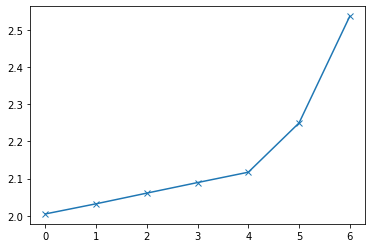

In [68]:
t_0 = actual_tracks_dict_all_with_headway[203][0,0]
t_end = 1500 #actual_tracks_dict_all_with_headway[207][-1,0]-50
print(t_0, t_end)


rmse_1sec_list = []
rmse_2sec_list = []
rmse_3sec_list = []
rmse_4sec_list = []
rmse_5sec_list = []
rmse_10sec_list = []
rmse_20sec_list = []

for t_i in range(t_0, t_end):
    t_0_i = t_i
    t_end_i = t_i+50
    
    tracks_xy_halluc_dict, rmse_list, _ = simulate_pos_bunch_pf(actual_tracks_dict_all_with_headway, \
                                                                p_mat_final_all_veh_filtered, p_mean_final_all_veh, lanes_rxy,\
                                                                t_0_i, t_end_i)

    print('\n\nRMSE....')
    for veh_id, track in tracks_xy_halluc_dict.items():

        indices = np.where(rmse_list[:,2] == veh_id)
        rmse_track = rmse_list[indices,:][0]
        print('veh_id', veh_id, 'rmse_track', rmse_track.shape)

        if len(rmse_track) >= 21:
#             rmse_1sec_list.append(np.mean((rmse_track[1, 0] - rmse_track[1, 1])**2))
#             rmse_2sec_list.append(np.mean((rmse_track[2, 0] - rmse_track[2, 1])**2))
#             rmse_3sec_list.append(np.mean((rmse_track[3, 0] - rmse_track[3, 1])**2))
#             rmse_4sec_list.append(np.mean((rmse_track[4, 0] - rmse_track[4, 1])**2))
#             rmse_5sec_list.append(np.mean((rmse_track[5, 0] - rmse_track[5, 1])**2))
#             rmse_10sec_list.append(np.mean((rmse_track[10, 0] - rmse_track[10, 1])**2))
#             rmse_20sec_list.append(np.mean((rmse_track[20, 0] - rmse_track[20, 1])**2))

            rmse_1sec_list.append(np.linalg.norm(rmse_track[1, 0] - rmse_track[1, 1]))
            rmse_2sec_list.append(np.linalg.norm(rmse_track[2, 0] - rmse_track[2, 1]))
            rmse_3sec_list.append(np.linalg.norm(rmse_track[3, 0] - rmse_track[3, 1]))
            rmse_4sec_list.append(np.linalg.norm(rmse_track[4, 0] - rmse_track[4, 1]))
            rmse_5sec_list.append(np.linalg.norm(rmse_track[5, 0] - rmse_track[5, 1]))
            rmse_10sec_list.append(np.linalg.norm(rmse_track[10, 0] - rmse_track[10, 1]))
            rmse_20sec_list.append(np.linalg.norm(rmse_track[20, 0] - rmse_track[20, 1]))
            
rmse_1sec_mean = np.mean(rmse_1sec_list)
rmse_2sec_mean = np.mean(rmse_2sec_list)
rmse_3sec_mean = np.mean(rmse_3sec_list)
rmse_4sec_mean = np.mean(rmse_4sec_list)
rmse_5sec_mean = np.mean(rmse_5sec_list)
rmse_10sec_mean = np.mean(rmse_10sec_list)
rmse_20sec_mean = np.mean(rmse_20sec_list)

x = range(7)
y = [rmse_1sec_mean, rmse_2sec_mean, rmse_3sec_mean, rmse_4sec_mean, rmse_5sec_mean, rmse_10sec_mean, rmse_20sec_mean]

plt.figure()
plt.plot(x,y, 'x-')
plt.show()


In [69]:
x_pf = x; y_pf = y;
pf_idm_mobil_results = {'x_pf': x_pf,'y_pf': y_pf}

with open('PF_IDM_MOBIL_5epochs_100particles_results.pkl', 'wb') as file:
    pickle.dump(pf_idm_mobil_results, file)  
    

In [76]:
## collisions

# print(tracks_xy_halluc_dict_pf.keys())
count = 0

for veh_id, track in tracks_xy_halluc_dict_pf.items():
    
    if veh_id == 203: 
        print('veh_id', veh_id, len(track))
        
        for t in range(len(track)):
            xy_ego = track[t, 1:3]

            for veh_id_other, track_other in tracks_xy_halluc_dict_pf.items():
                if veh_id < veh_id_other:
                    distance = np.min(cdist(np.array([xy_ego]), track_other[:,1:3], 'euclidean'))
                    
                    
                    if distance < 1.5:
                        print(t, veh_id_other, distance)
                        count += 1

print(count)

veh_id 203 238
0 207 0.4068492251982837
1 207 0.41586290738044795
2 207 0.40678202515345474
3 207 0.4037550632759278
4 207 0.4069171895441629
5 207 0.4157318603026738
6 207 0.406715570483269
7 207 0.40375618273517044
8 207 0.40698588332924707
9 207 0.41560147628323235
10 207 0.40664984157822154
11 207 0.4037580485144252
12 207 0.40705530713522
13 207 0.41547178108914334
14 207 0.40658484376136594
15 207 0.40376066062292626
16 207 0.4071254611522969
17 207 0.4153427701532542
18 207 0.4065205758862772
19 207 0.40376401906540826
20 207 0.4071963447048876
21 207 0.41521444467340984
22 207 0.4064570387341303
23 207 0.4037681238429194
24 207 0.40726795761409035
25 207 0.41508680525944974
26 207 0.4063942324953285
27 207 0.403772974953826
28 207 0.4073402994892351
29 207 0.4149598524253008
30 207 0.4063321575172881
31 207 0.4037785723927231
32 207 0.4074133700121364
33 207 0.41483358677343424
34 207 0.4062708141170808
35 207 0.40378491615091805
36 207 0.4074871688358614
37 207 0.4147080088642

In [65]:
## hard braking

# print(tracks_xy_halluc_dict_pf.keys())
for veh_id, track in tracks_xy_halluc_dict_pf.items():
    if veh_id == 206: #> 201 and veh_id < 210:
        for t in range(len(track)-1):
            vsvd = track[t+1, 3:5] - track[t, 3:5]
            asad = track[t+1, 5:7] - track[t, 5:7]
            print(t, vsvd)



dict_keys([203, 204, 206, 207, 208])
0 [0.6519128697394319 0.0]
1 [0.6519128697394319 0.0]
2 [0.6519128697394319 0.0]
3 [0.6519128697394319 0.0]
4 [0.6519128697394319 0.0]
5 [0.6519128697394319 0.0]
6 [0.6519128697394319 0.0]
7 [0.6519128697394319 0.0]
8 [0.6519128697394319 0.0]
9 [0.6519128697394319 0.0]
10 [0.6519128697394336 0.0]
11 [0.6519128697394336 0.0]
12 [0.6519128697394336 0.0]
13 [0.6519128697394336 0.0]
14 [0.6519128697394336 0.0]
15 [0.6519128697394336 0.0]
16 [0.6519128697394336 0.0]
17 [0.6519128697394336 0.0]
18 [0.6519128697394336 0.0]
19 [0.6519128697394336 0.0]
20 [0.6519128697394336 0.0]
21 [0.6519128697394336 0.0]
22 [0.6519128697394336 0.0]
23 [0.6519128697394336 0.0]
24 [0.6519128697394336 0.0]
25 [0.6519128697394336 0.0]
26 [0.6519128697394336 0.0]
27 [0.6519128697394336 0.0]
28 [0.6519128697394336 0.0]
29 [0.6519128697394336 0.0]
30 [0.6519128697394336 0.0]
31 [0.6519128697394336 0.0]
32 [0.6519128697394336 0.0]
33 [0.6519128697394336 0.0]
34 [0.651912869739430

In [623]:
def compute_rmse(tracks_xy_halluc_dict, rmse_list):

    rmse_1sec_list = []
    rmse_5sec_list = []
    rmse_10sec_list = []
    rmse_20sec_list = []

    for veh_id, track in tracks_xy_halluc_dict.items():

        if veh_id >=2 and veh_id < 120:
            indices = np.where(rmse_list[:,2] == veh_id)
            rmse_track = rmse_list[indices,:][0]
            print('veh_id', veh_id, 'rmse_track', rmse_track.shape)

            rmse_1sec_list.append(np.mean((rmse_track[1, 0] - rmse_track[1, 1])**2))
            rmse_5sec_list.append(np.mean((rmse_track[5, 0] - rmse_track[5, 1])**2))
            rmse_10sec_list.append(np.mean((rmse_track[10, 0] - rmse_track[10, 1])**2))
            rmse_20sec_list.append(np.mean((rmse_track[20, 0] - rmse_track[20, 1])**2))
        
    rmse_1sec_mean = np.mean(rmse_1sec_list)
    rmse_5sec_mean = np.mean(rmse_5sec_list)
    rmse_10sec_mean = np.mean(rmse_10sec_list)
    rmse_20sec_mean = np.mean(rmse_20sec_list)
    
    return [rmse_1sec_mean, rmse_5sec_mean, rmse_10sec_mean, rmse_20sec_mean]

In [931]:
p_mean_final_all_veh

{11: array([1.29445093, 0.20409022, 0.4010515 , 0.86865736]),
 32: array([1.24368418, 0.18709704, 0.35961096, 0.81803044]),
 33: array([1.16829224, 0.18089515, 0.33586842, 0.72093981]),
 35: array([1.34878121, 0.18180354, 0.35499568, 0.80309066]),
 39: array([1.26597116, 0.19770974, 0.23722396, 0.83991475]),
 41: array([1.3620084 , 0.21409094, 0.24315999, 0.90693288]),
 44: array([1.2691623 , 0.1704249 , 0.23429002, 0.83399044]),
 46: array([1.38225028, 0.20920899, 0.36994452, 0.87512327]),
 47: array([1.34020497, 0.19073453, 0.28982695, 0.77532744]),
 52: array([1.25758142, 0.1832243 , 0.24032263, 0.7821245 ]),
 53: array([1.17396026, 0.1817767 , 0.26715626, 0.67704379]),
 55: array([1.32486441, 0.18883081, 0.38742552, 0.79263439]),
 57: array([1.29204046, 0.20176332, 0.36953753, 0.8243256 ]),
 61: array([1.22275565, 0.21542579, 0.28870303, 0.77448098]),
 63: array([1.22413155, 0.20414347, 0.26656228, 0.73641216]),
 65: array([1.50537972, 0.17651238, 0.27346312, 0.772932  ]),
 69: arr